# Auswertung der Temperaturdaten des Sensor.Community-Projekts
Christoph Wald, Wiederverwendbar nach MIT-Lizenz

### Disclaimer: Da die Daten nur den Zeitraum von 7 Jahren umfassen, ist auf Grundlage der Daten keine Aussagen über Klimawandel möglich. Weder deuten Varianzen auf Veränderungen des Klimas hin noch sind beobachtbare Invarianzen Gegenbeweise für den Klimawandel. 

Wikipedia:  Um neben allen anderen Witterungsvorgängen auch den Temperaturverlauf in einem statistisch relevanten Zeitrahmen mit ausreichender Genauigkeit darzustellen, empfiehlt die Weltorganisation für Meteorologie (WMO) die Verwendung von Referenzperioden (auch Normalperioden oder CLINO-Perioden), in denen die Monatsmittelwerte als Zeitreihe über 30 Jahre in einem Datensatz zusammengefasst werden.


noch ein Disclaimer: Nach Download der Daten und Erstellung der Präsention wurde die Datenbank noch ergänzt. Neu heruntergeladen wurden vorerst nur bruessel2018, bruessel2021, bruessel2022, bruessel2024 sowie sofia2022, berlin 2022.

In [1]:
pip install cartopy

  Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached Cartopy-0.24.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
#function to generate all filenames containing the downloaded data
years = np.arange(2018,2025)
places = ["bruessel", "sofia", "berlin", "paris", "moskau", "stockholm"]

def generate_filenames(years, places):
    for place in places:
        for year in years:
            filename = "data/" + place + str(year) +".csv"
            yield(filename)

- Die Zellen oben bitte zuerst ausführen. 
- Teil 1 kann übersprungen werden.
- Die Ausführung des gesamten Notebooks dauert ca. 3-5 Minuten

### 1. Datenbeschaffung

#### Zeitraum
Temperaturdaten werden erst seit 2016 erfasst. Seit 2017 gibt es Sensoren, die durchgängig mindestens einmal pro Stunde einen Wert messen, seit 2018 gibt es ausreichend Sensoren in einem der ausgewählten Bereiche.

#### Flächen
Da die Messungen der Sensoren starke Varianzen aufweichen (z.B. aufgrund der Sonneneinstrahlung) wurden Bereiche ausgewählt, in denen eine große Anzahl von Sensoren vorhanden ist. Dazu wurde um die Zentren europäischer Hauptstäde in einem Quadrat mit +/- 0.1 Grad in beide Richtungen gesucht (die tatsächliche Fläche unterscheidet sich dann je nach geographischer Position).

#### Pre-Pre-Processing
Um die Menge der Daten zu begrenzen wurden vor dem Speichern der Daten für jeden Sensor und jede Stunde ein arithmetisches Mittel gebildet. Siehe das gesonderte Notebook get-data.ipynb mit einem Template zur Beschaffung der Daten.

#### Räumliche Verteilung der ausgewählten Sensoren

In [4]:
#bounding boxes für die ausgewählten Regionen
city_names = [
    "Bruxelles / Brüssel", "Sofiya / Sofia", "Berlin", "Paris", "Moskva / Moskau", "Stockholm"
]

city_coordinates = [
    [50.8371, 4.3676],
    [42.7105, 23.3238],
    [52.5235, 13.4115],
    [48.8567, 2.3510],
    [55.7558, 37.6176],
    [59.3328, 18.0645],
]

#taken from https://www.nobochamp.de/hauptstaedte.html

rectangles = []
for c in city_coordinates:
    rectangles.append([c[1]-0.1, c[0]-0.1, c[1]+0.1, c[0]+0.1]) #Längen-/Breitengrad vertauschen und mit +/-0.1 zum Rechteck machen
for i in range(len(city_names)):
    print(f"{city_names[i]}: {rectangles[i][0]:.2f}, {rectangles[i][1]:.2f}")

Bruxelles / Brüssel: 4.27, 50.74
Sofiya / Sofia: 23.22, 42.61
Berlin: 13.31, 52.42
Paris: 2.25, 48.76
Moskva / Moskau: 37.52, 55.66
Stockholm: 17.96, 59.23


In [5]:
#sammle die Koordinaten aller Sensoren in einer Liste points
unique_combinations = pd.DataFrame([])
for filename in generate_filenames(years, places):
    #print(filename)
    df = pd.read_csv(filename)
    unique_combinations_new = df[['lat', 'lon']].drop_duplicates()
    if len(unique_combinations_new) > 0: unique_combinations = pd.concat([unique_combinations, unique_combinations_new])
unique_combinations[['lat', 'lon']].drop_duplicates()
points = list(zip(unique_combinations['lat'], unique_combinations['lon']))

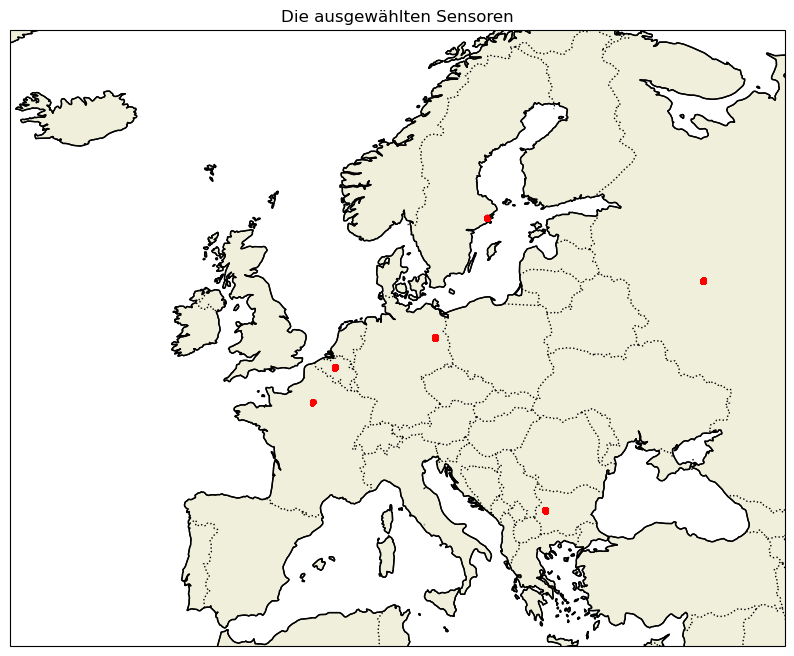

In [6]:
#Zeige alle Sensoren auf der Europakarte
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

for lat, lon in points:
    plt.plot(lon, lat, marker='o', color='red', markersize=2, transform=ccrs.PlateCarree())

ax.set_extent([-25, 45, 35, 70], crs=ccrs.PlateCarree()) #etwa Europa
ax.set_aspect('auto') 

plt.title("Die ausgewählten Sensoren")
plt.show()


#### Dichte der Messdaten der ausgewählten Sensoren

In [7]:
#Sammle die Anzahl der Messungen jedes Sensor in einer Liste hist_data
hist_data = []
for place in places:
    counts = []
    for filename in generate_filenames(years, [place]):
        #print(filename)
        data = pd.read_csv(filename)
        unique_sensors = data["sensor_id"].unique()
        sensor_entry_counts = pd.DataFrame({
            'sensor_id': unique_sensors,
            'entry_count': [len(data[data.sensor_id == s]) for s in unique_sensors]
        })
        counts.append(sensor_entry_counts['entry_count'].to_numpy())
    hist_data.append(counts)

In [8]:
#Erstelle ein Dataframe results_df das pro Jahr/Ort die Anzahl der Sensoren mit mehr als 4000 und mehr als 8000 Sensoren enthält
#maximal: 24*365 = 8760
results = []
for i, city_data in enumerate(hist_data):
    for j, yearly_data in enumerate(city_data):
        count_gt_4000 = np.sum(yearly_data > 4000)  # Count of data > 4000
        count_gt_8000 = np.sum(yearly_data > 8000)  # Count of data > 8000
        results.append({
            "City": places[i],
            "Year": years[j],
            "Count > 4000": count_gt_4000,
            "Count > 8000": count_gt_8000
        })
results_df = pd.DataFrame(results)
results_df

City  Year  Count > 4000  Count > 8000
0    bruessel  2018            51             4
1    bruessel  2019           286            33
2    bruessel  2020           315            92
3    bruessel  2021           191             0
4    bruessel  2022           179            94
5    bruessel  2023           126            84
6    bruessel  2024            76             0
7       sofia  2018           296            97
8       sofia  2019           333           149
9       sofia  2020           375           106
10      sofia  2021           314             0
11      sofia  2022           294           159
12      sofia  2023           280           145
13      sofia  2024           158             0
14     berlin  2018           113            41
15     berlin  2019           166            76
16     berlin  2020           196            76
17     berlin  2021           175             0
18     berlin  2022           183            96
19     berlin  2023           154            97
20     berlin  2024            76             0
21      paris  2018             2             0
22      paris  2019             6             0
23      paris  2020             9             1
24      paris  2021             5             0
25      paris  2022             0             0
26      paris  2023            40             0
27      paris  2024            19             0
28     moskau  2018             0             0
29     moskau  2019             0             0
30     moskau  2020            27             0
31     moskau  2021            27             0
32     moskau  2022             0             0
33     moskau  2023            29             0
34     moskau  2024             0             0
35  stockholm  2018            14             0
36  stockholm  2019            36            11
37  stockholm  2020            25             0
38  stockholm  2021            17             0
39  stockholm  2022             0             0
40  stockholm  2023            15             0
41  stockholm  2024             0             0

In [9]:
#Histogramme in einem grid für 3 Städte und 7 Jahre
def plot_histograms(data, threshold1, threshold2):
    fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(40, 15), sharex=True, sharey=True)
    for i, city_data in enumerate(data):
        for j, yearly_data in enumerate(city_data):
            ax = axes[i, j]  
            ax.hist(yearly_data, bins=20, alpha=0.7, color='blue')  

            if np.all(yearly_data <= threshold1) and np.all(yearly_data <= threshold2):
                ax.set_facecolor("red")
            elif np.all(yearly_data <= threshold1):
                ax.set_facecolor('orange')
            else:
                ax.set_facecolor('lightgreen')  
            
            if i == 0:
                ax.set_title(f"{years[j]}")
            if j == 0:
                ax.set_ylabel(f"{places[i]}")

    plt.tight_layout()
    #plt.savefig("histograms.png")
    plt.show()

#Verteilungen der Messdaten über die Tage des Jahres
def plot_distributions(selected_places, selected_years):
    count_measurements = []
    for place in selected_places:
        counts = []
        for filename in generate_filenames(selected_years, [place]):
            #print(filename)
            df = pd.read_csv(filename)
            date_counts = df.groupby('date').size().reset_index(name='count')
            count_measurements.append(date_counts) 
    
    for i, year in enumerate(selected_years):
        plt.figure(figsize=(20,4))
        for j, place in enumerate(selected_places):
            plt.title(str(year))
            plt.xlabel("time")
            plt.ylabel("number of measurements")
            plt.scatter(count_measurements[i+j*3]["date"], count_measurements[i+j*3]["count"], label = place)
        plt.legend()
        #plt.savefig(str(year) + ".png")
        plt.show()

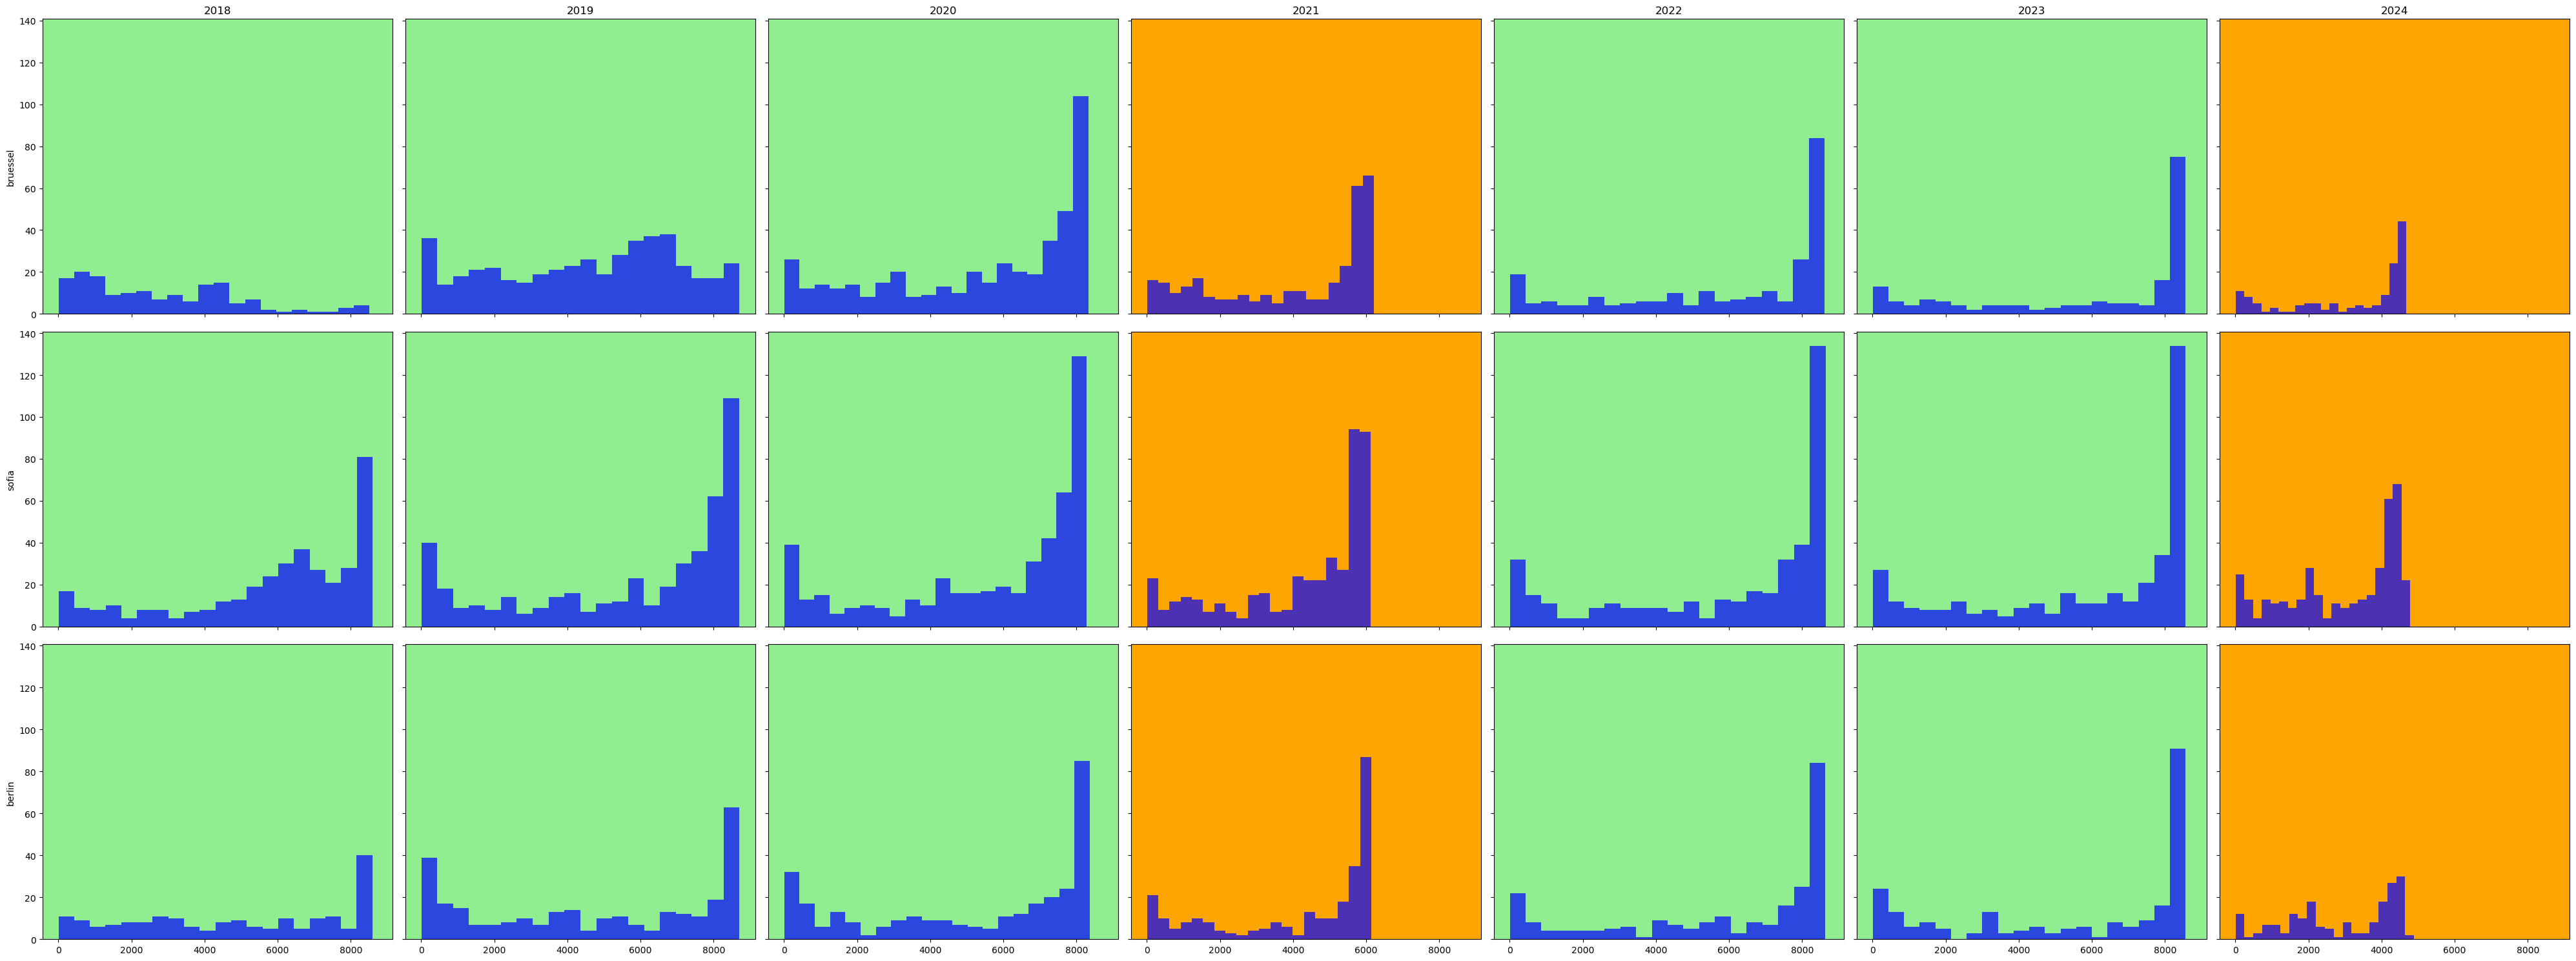

In [10]:
#Zeige die Histogramme für die ersten drei Städte Brüssel, Berlin und Sofia
#thresholds für die Hintergründe
plot_histograms(hist_data[:3], threshold1 = 8000, threshold2 = 4000)

##### Grün: Mindestens ein Sensor mit mind. 8000 Sensordaten pro Jahr
##### Orange: Mindestens ein Sensor mit mind. 4000 Sensordaten pro Jahr
##### Rot: Alle Sensoren weniger als 4000 Sensordaten pro Jahr

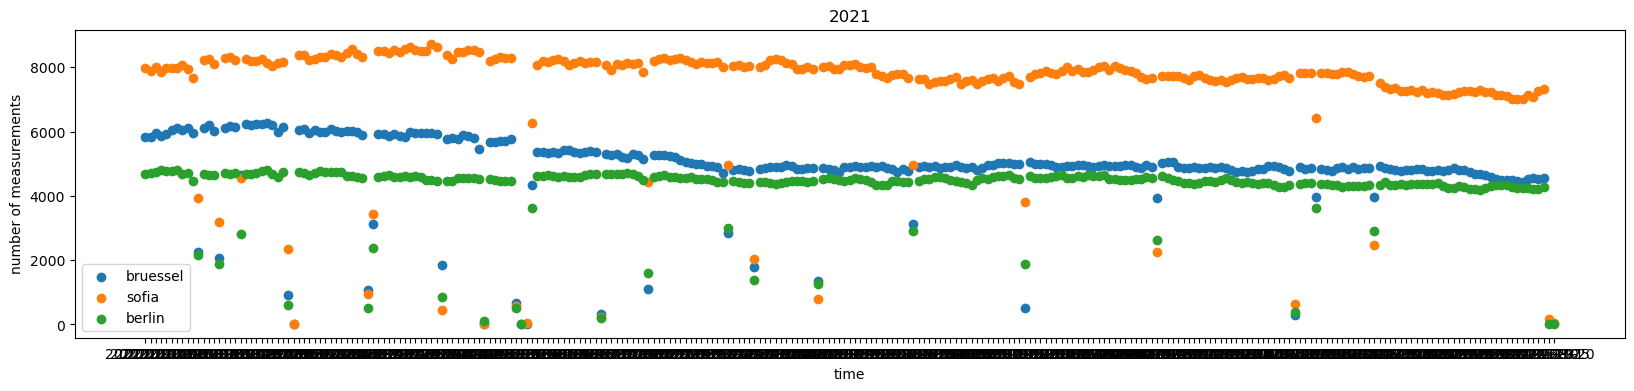

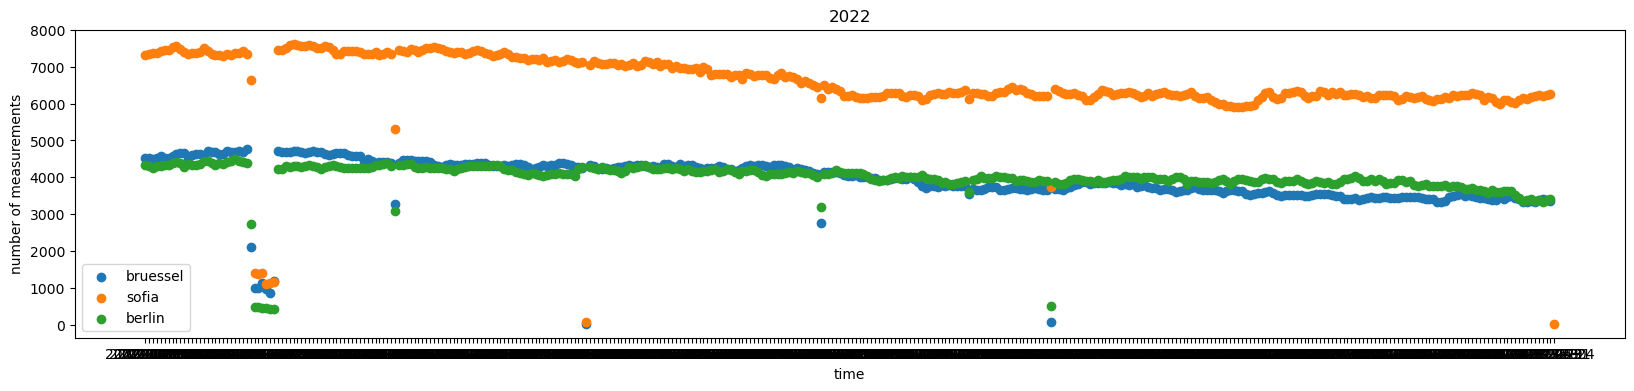

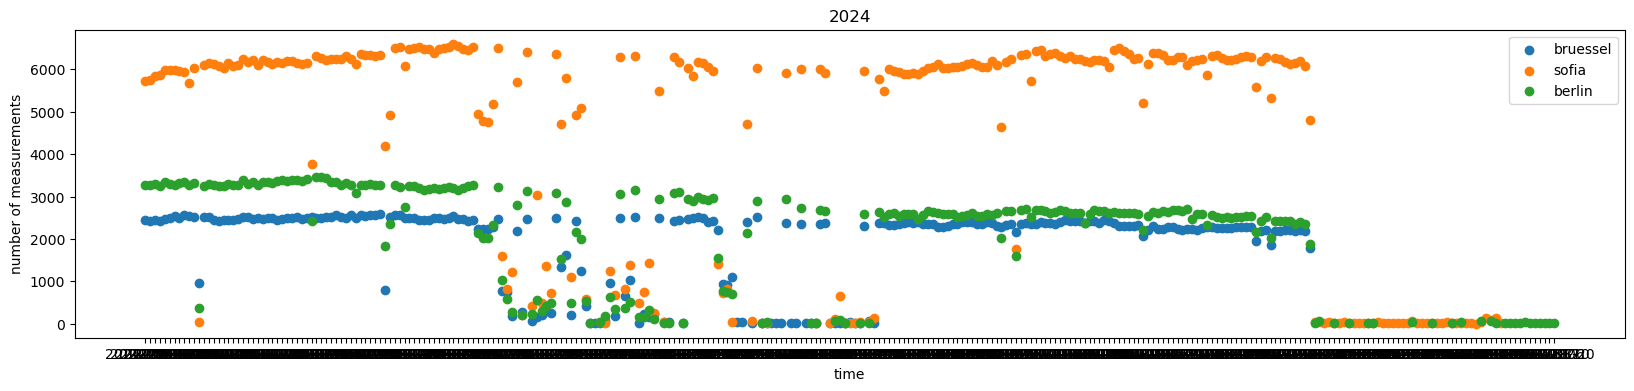

In [11]:
#für die problematische Jahre (21,22,24): zeige die Verteilung der Daten über das Jahr
plot_distributions(places[:3], [2021,2022,2024])

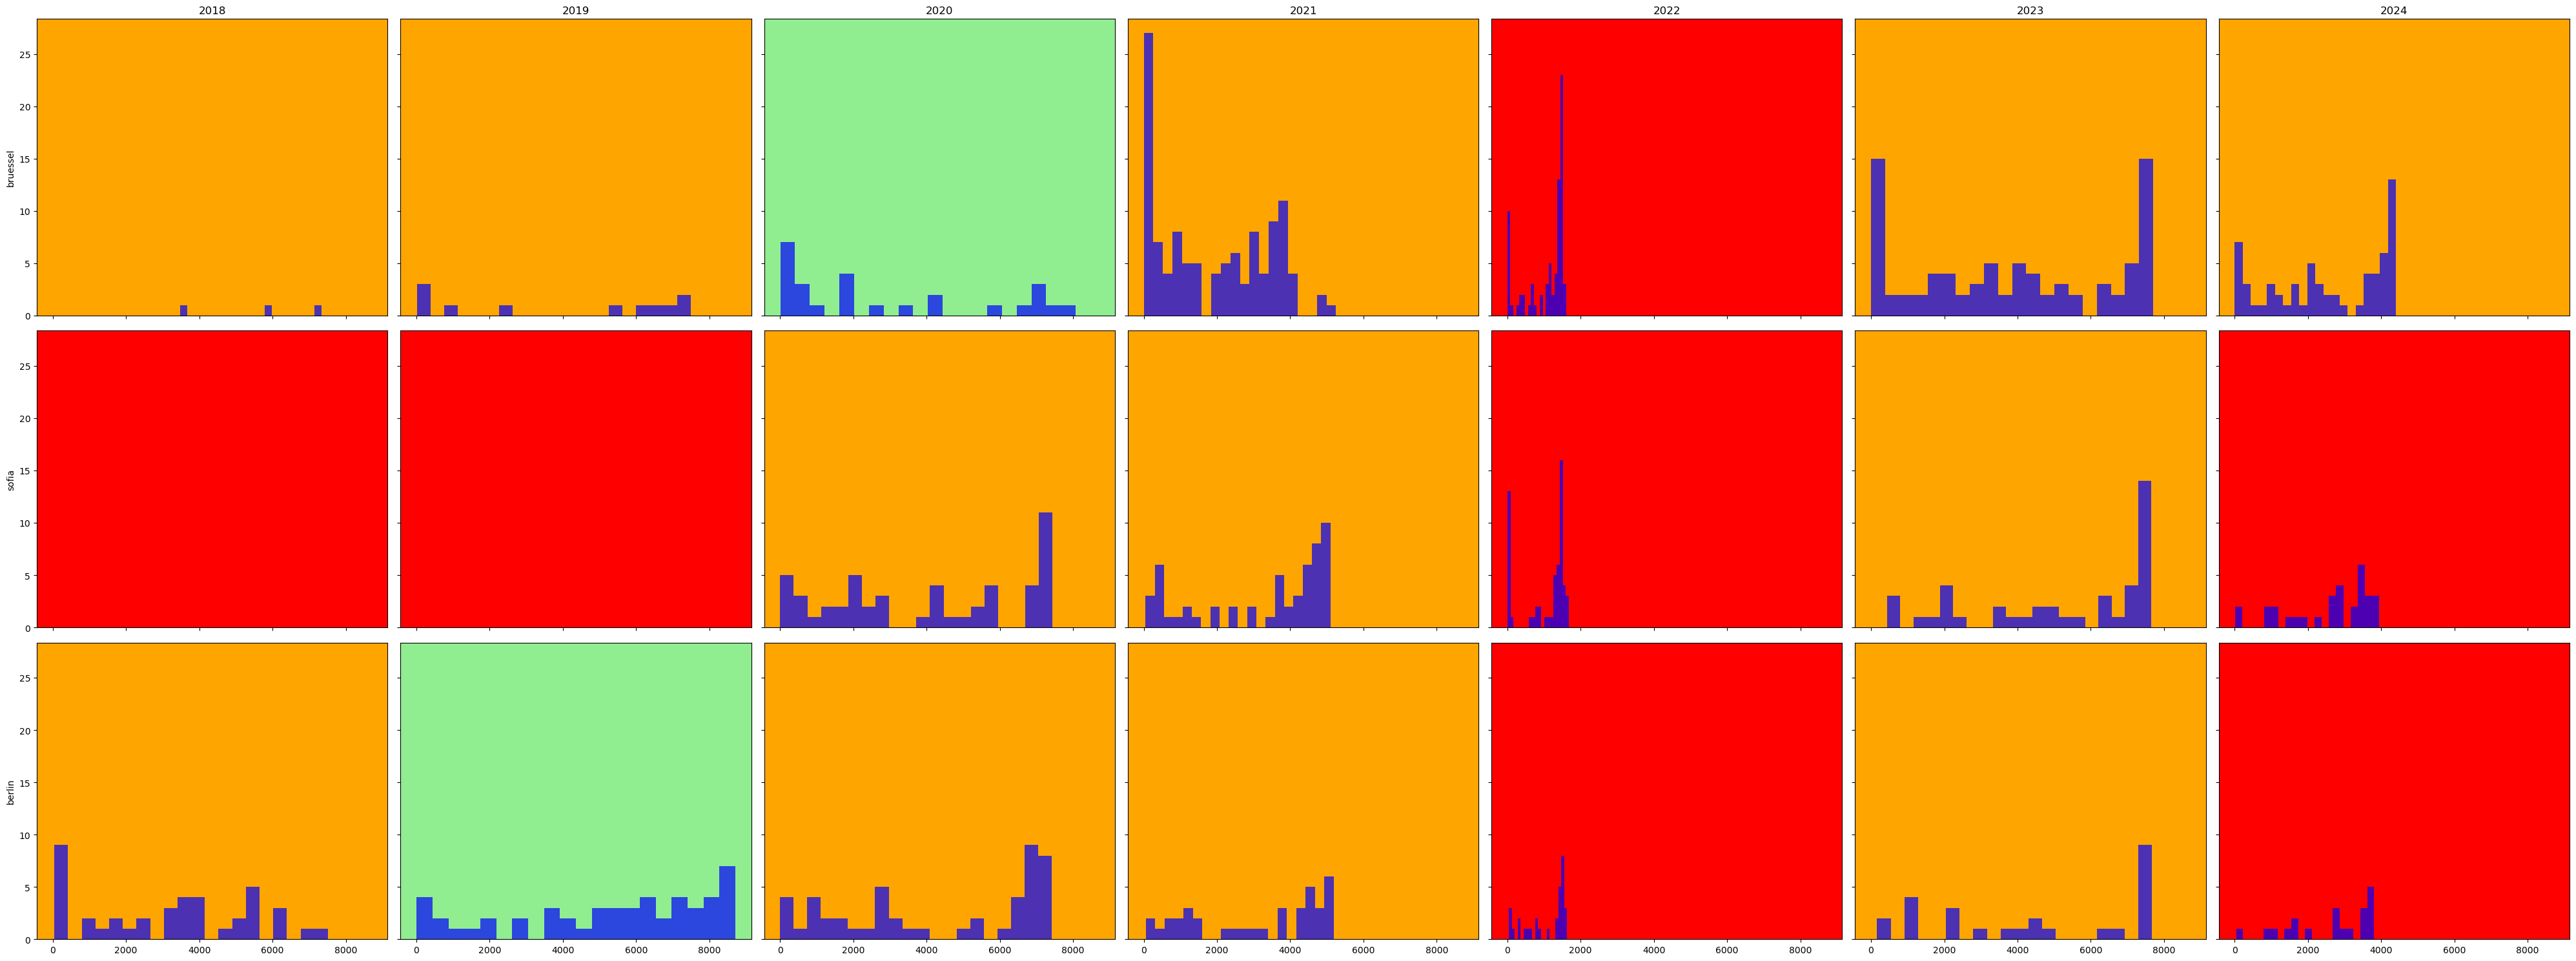

In [12]:
#Zeige die Histogramme für die Städte mit weniger Sensordaten (Paris, Moskau, Stockholm)
#thresholds für die Hintergründe
plot_histograms(hist_data[3:], threshold1 = 8000, threshold2 = 4000)

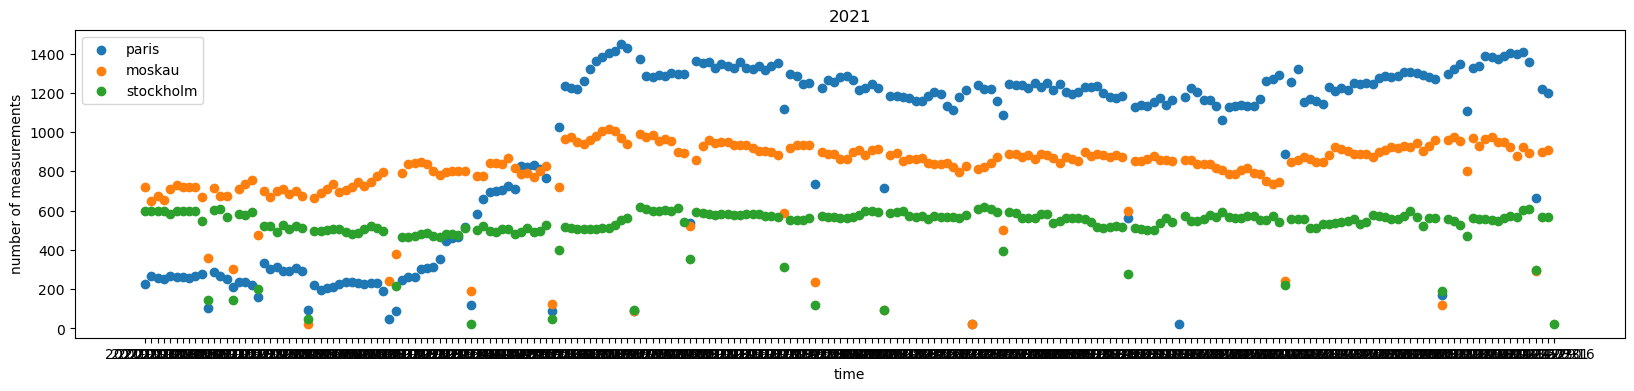

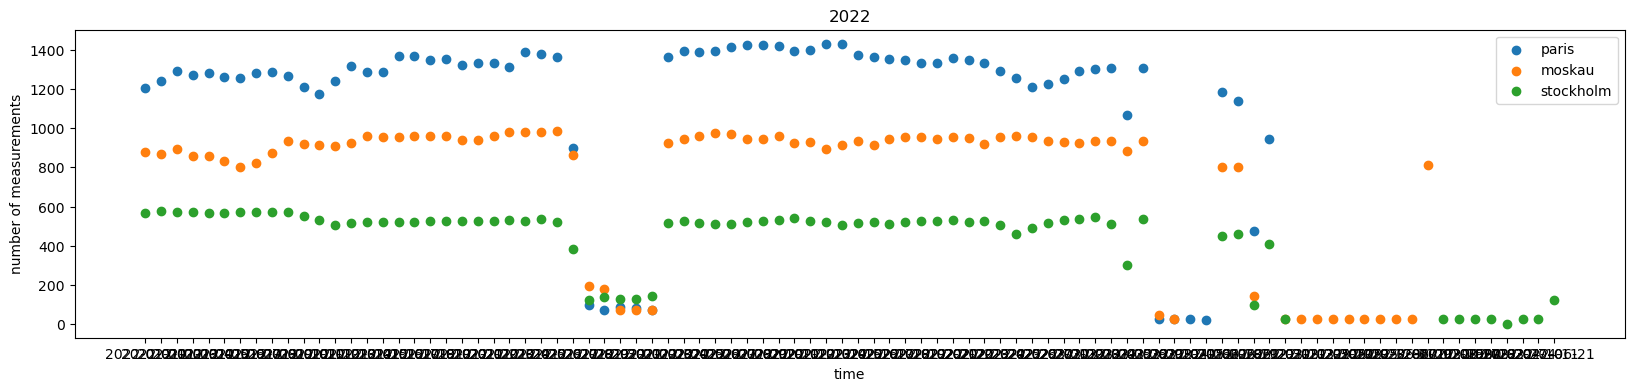

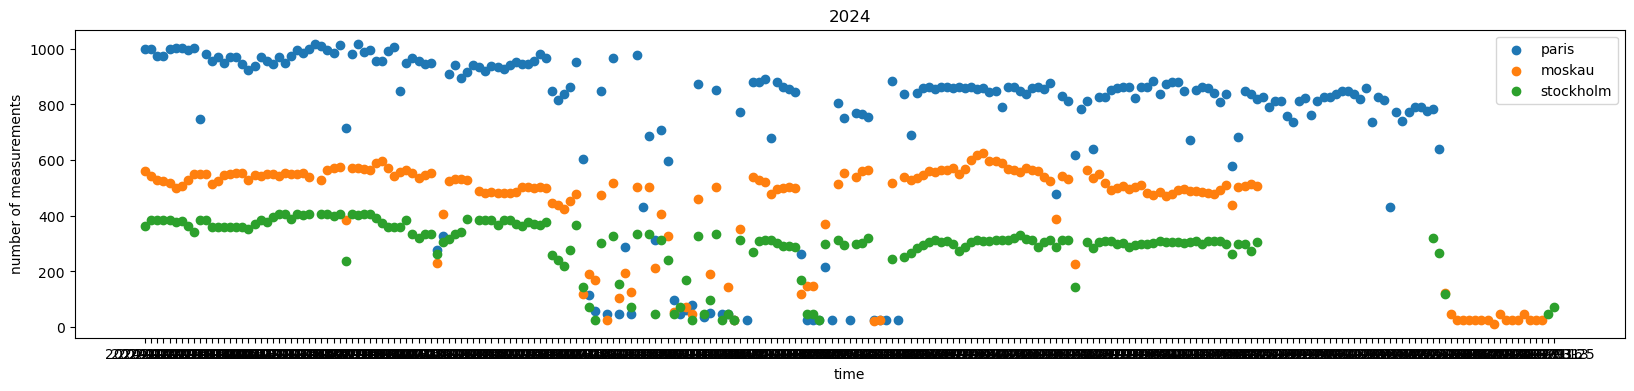

In [13]:
#für die problematische Jahre (21,22,24): zeige die Verteilung der Daten über das Jahr
plot_distributions(places[3:], [2021,2022,2024])

### 2. Datenbereinigung

#### Zwischenspeicherung
In der folgenden Zelle werden die Daten der drei Städte Berlin, Brüssel und Sofia gefiltert. Nur Sensoren mit mindestens 4000 Messwerten pro Jahr werden behalten. Die Ergebnisse werden jeweils in einer .csv gespeichert. Die Zelle ist als "raw" formatiert, damit sie nicht automatisch ausgeführt werden kan..

Wegen der unzureichenden Datenmenge für Paris, Stockholm und Moskau wurden die Daten dieser Städte nicht vollständig ausgewertet. Eine grobe Analyse enthält das Notebook final_small_cities.ipynb.

In [4]:
#Daten aus Datei laden und eine Spalte für "Jahr" hinzufügen
def load_data(place):
    df = pd.read_csv(place+".csv")
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    return df
    
#prozentualen Anteil der Extremwerte anzeigen
def show_extremes(dfs, lower_bound = -20, upper_bound = 40):
    print("Messpunkte mit Temperaturwerten > 40° und < -20°")
    for i in range(3):
        extreme = len(dfs[i][(dfs[i]["temperature_mean"] < lower_bound) | (dfs[i]["temperature_mean"] > upper_bound)])
        all = len(dfs[i])
        
        print(f"{places[i]}: {extreme}, entsprechen {100*extreme/all:.2f}%")

In [5]:
#Daten der drei Städte in Liste raw_dfs laden und Extremwerte zeigen
raw_dfs = []
for place in places[:3]:
    print(f"Loading {place}")
    raw_df = load_data(place)
    raw_dfs.append(raw_df)    
show_extremes(raw_dfs)

Loading bruessel
Loading sofia
Loading berlin
Messpunkte mit Temperaturwerten > 40° und < -20°
bruessel: 39947, entsprechen 0.50%
sofia: 493887, entsprechen 3.57%
berlin: 135546, entsprechen 1.87%


#### 2.1: Unrealistische Extremwerte rausfiltern (damit der Boxplot überhaupt auf den Bildschirm passt) 

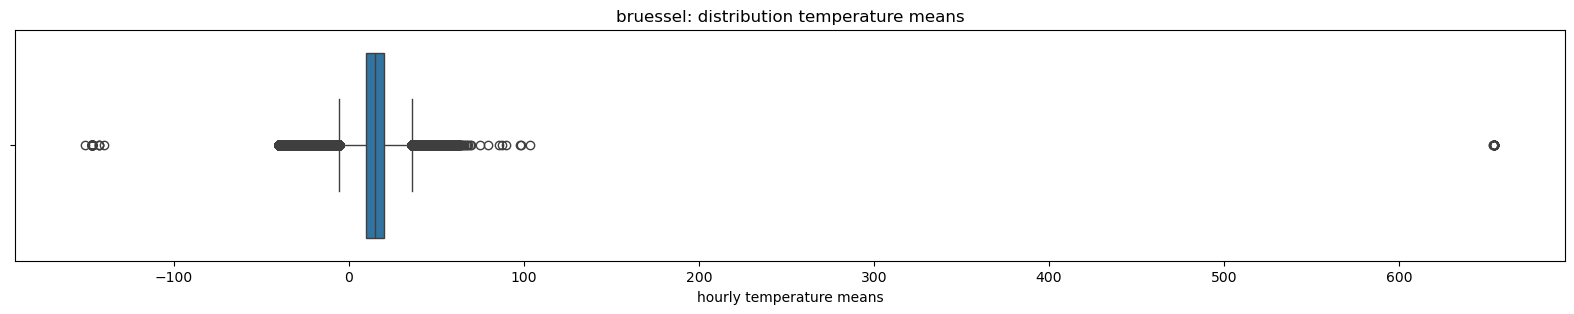

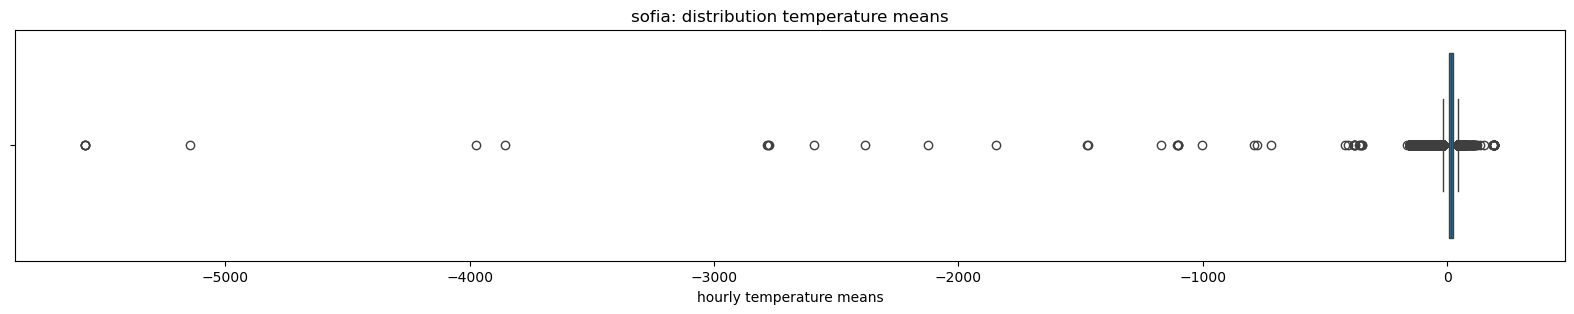

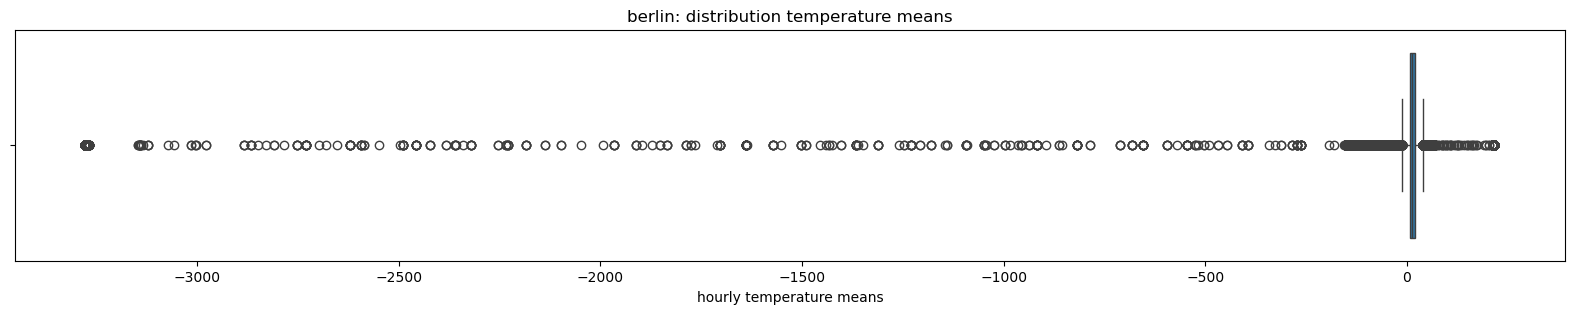

In [6]:
#Boxplot der Datenverteilung
def create_boxplot(df, place):
    plt.figure(figsize=(20,3))
    sns.boxplot(data = df, x="temperature_mean")
    plt.title(place + ": distribution temperature means")
    plt.xlabel("hourly temperature means")
    plt.show()

for i in range(3):
    create_boxplot(raw_dfs[i], places[i])

In [7]:
#erstellen einer Liste dfs die keine Messungen mit völlig unrealistischen Werten enthält
#niedrigste gemessene Temperatur: -89.2, höchste gemessene Temperatur: 56.7
dfs = []
for i,df in enumerate(raw_dfs):
    dfs.append(df[(df["temperature_mean"] > -90) & (df["temperature_mean"] < 90 )])
    print(f"{places[i]}: filtered out {len(raw_dfs[i]) - len(dfs[i])} datapoints.")
show_extremes(dfs)

bruessel: filtered out 92 datapoints.
sofia: filtered out 426809 datapoints.
berlin: filtered out 111880 datapoints.
Messpunkte mit Temperaturwerten > 40° und < -20°
bruessel: 39855, entsprechen 0.50%
sofia: 67078, entsprechen 0.50%
berlin: 23666, entsprechen 0.33%


#### 2.2 Outlier-Detection

Vorgehen:

- Alle Outlier, die im 10. oder 90. Perzentil liegen, werden identifiziert und entfernt.
- Sensoren, die mehr als 71 Werte in diesen Perzentilbereichen aufweisen (entspricht 72 Werten = 3 Tage), werden vollständig aus dem Datensatz entfernt.

Dieses Vorgehen führt zu geringfügigen Änderungen bei den Extremwerten (siehe unten).

Alternative Ansätze:

- Die klassischen 25. und 75. Perzentile wurden ebenfalls getestet. Diese Methode führte zur Entfernung fast aller extremen Werte (> 40 °C, < -20 °C), jedoch auch zu einem sehr hohen lower bound von -5 °C.
- Zusätzlich wurde die Outlier-Detection separat für einzelne Jahre getestet, jeweils mit beiden Interquartilsabständen (80 % und 50 %). Diese Tests zeigten jedoch keine Veränderungen in den Ergebnissen.

Keiner der getesteten Ansätze führte zu nennenswerten Unterschieden bei der anschließenden Datenanalyse.

In [8]:

#Berechnung der outlier, gibt einen Dataframe zurpcl
def calc_outliers(df, lower = 0.1, upper = 0.9):
    Q1 = df["temperature_mean"].quantile(lower)
    Q3 = df["temperature_mean"].quantile(upper)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Lower Bound: {lower_bound:.2f}")
    print(f"Upper Bound: {upper_bound:.2f}")
    
    return df[(df["temperature_mean"] < lower_bound) | (df["temperature_mean"] > upper_bound)]

#Scatterplot der Outlier
def plot_outliers(outliers, place):
    plt.figure(figsize=(20, 3))
    sns.scatterplot(data=outliers, x="date", y="temperature_mean", hue="sensor_id", palette="Set1", legend=False)
    plt.title(place + ': outliers with color-coded sensors_ids', fontsize=14)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('temperature mean', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#Verteilung von Sensordaten über die Zeit
def plot_bads(bad_sensor, place):
    plt.figure(figsize=(20, 3))
    for sensor_id, group in bad_data.groupby('sensor_id'):
        plt.plot(group['date'], group['temperature_mean'], label=f"Sensor {sensor_id}")
    plt.xlabel('date')
    plt.ylabel('temperature')
    plt.title(place + ': sensor data of really faulty sensors')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

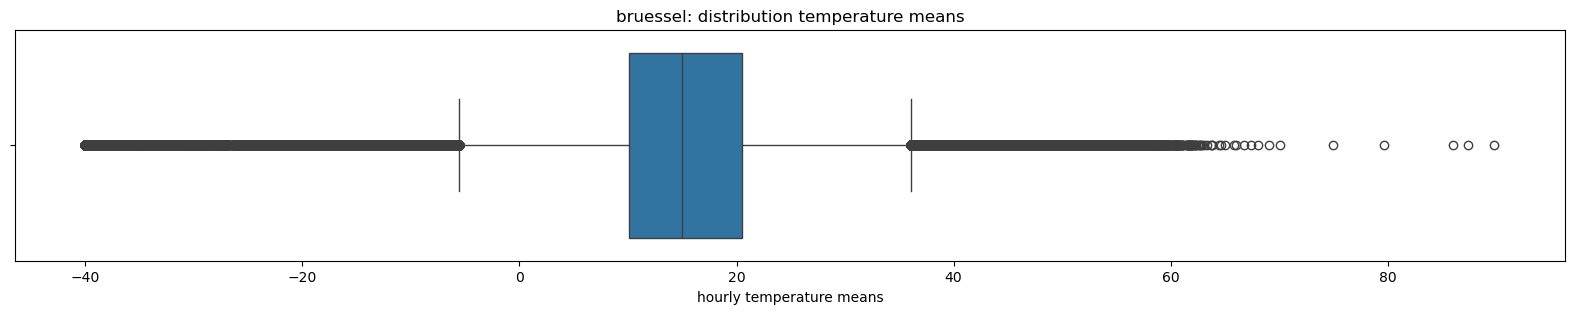

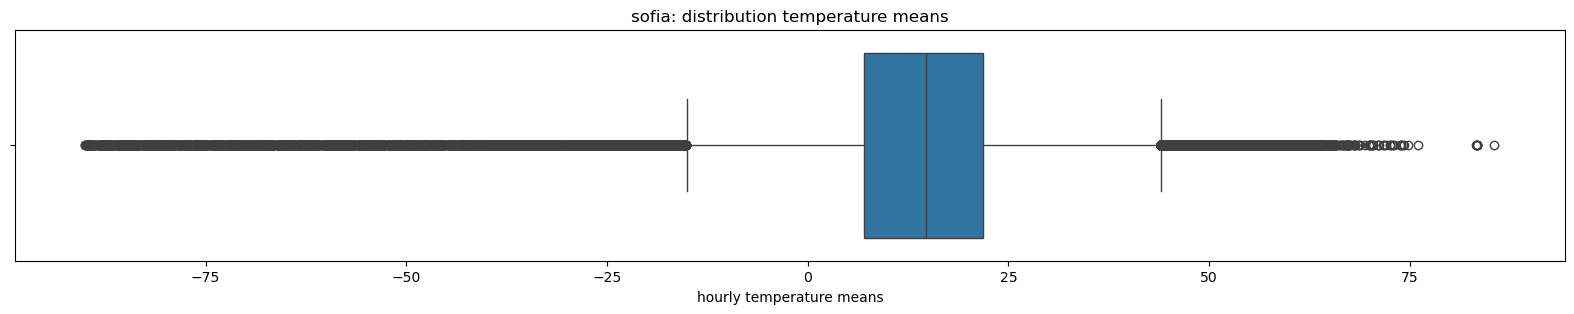

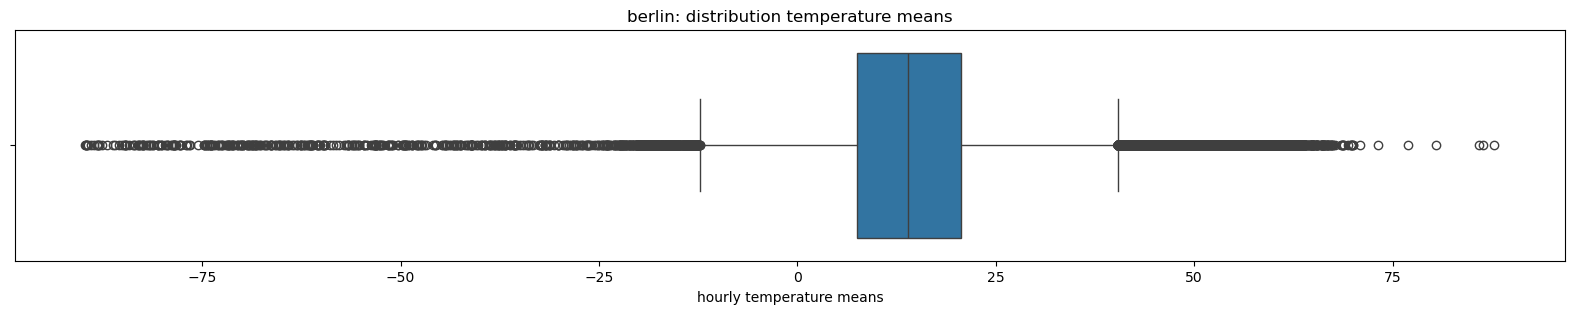

In [9]:
for i in range(3):
    create_boxplot(dfs[i], places[i])

In [10]:
#erstellt eine Liste mit den outliern (nach Städten getrennt)
outliers = []
for i in range(3):
    print(places[i])
    out = calc_outliers(dfs[i])
    outliers.append(out)
    print(f"{len(out)} outliers detected.")
    print("Unique sensors:", len(out["sensor_id"].unique()))

bruessel
Lower Bound: -21.54
Upper Bound: 53.37
4190 outliers detected.
Unique sensors: 78
sofia
Lower Bound: -35.15
Upper Bound: 65.07
1921 outliers detected.
Unique sensors: 193
berlin
Lower Bound: -29.52
Upper Bound: 58.49
874 outliers detected.
Unique sensors: 52


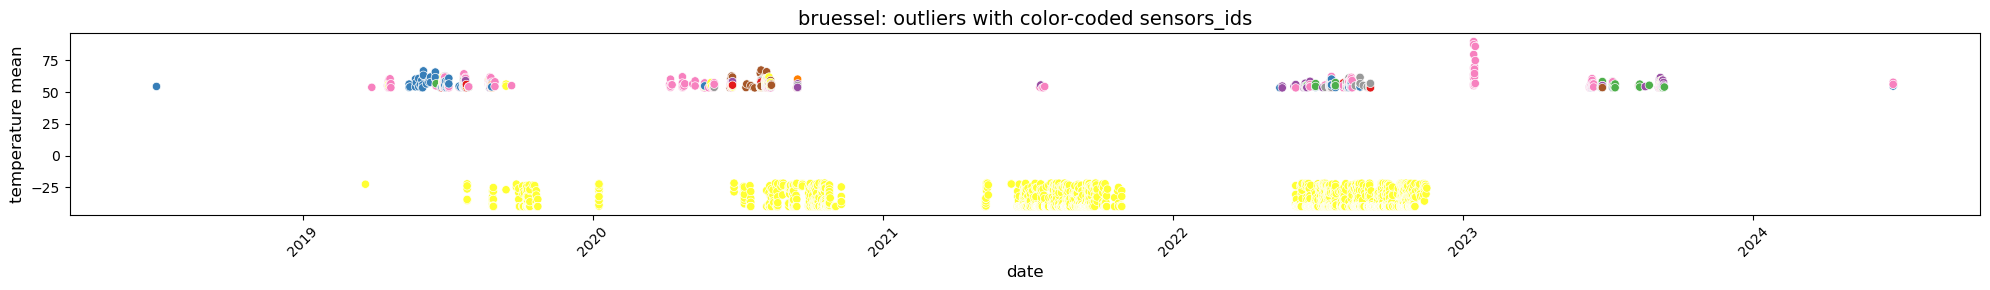

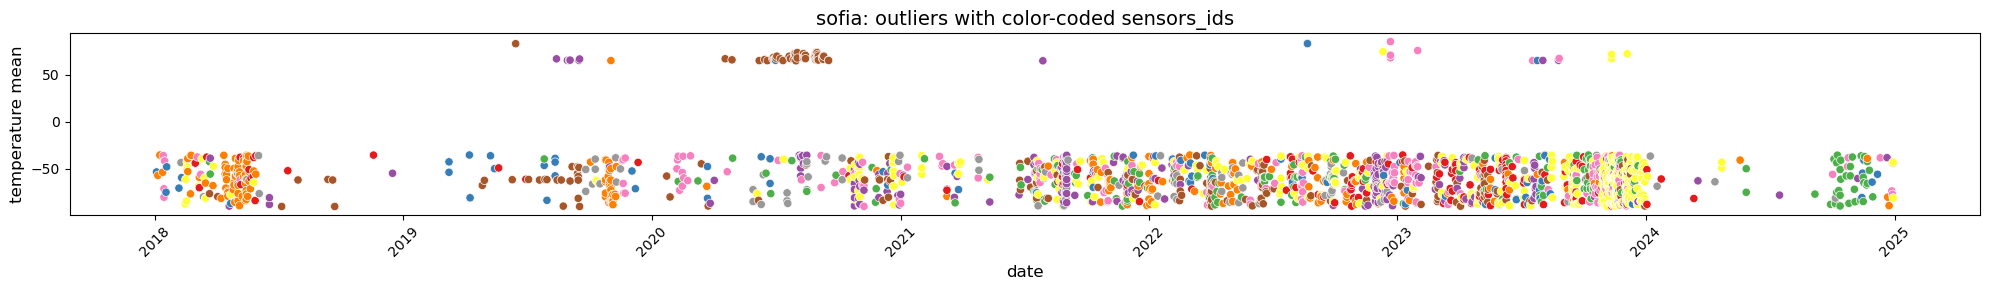

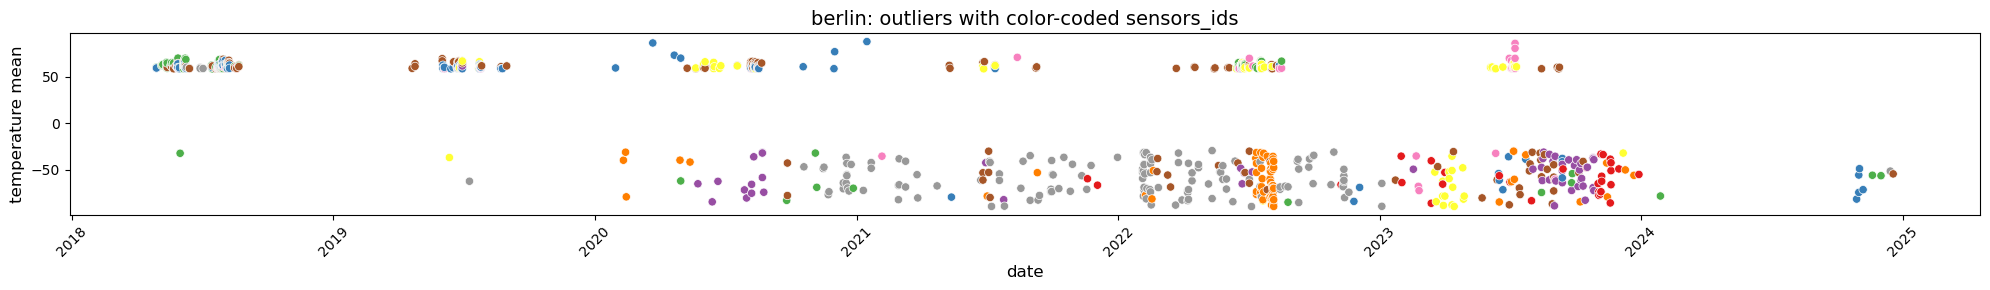

In [11]:
#zeigt die Verteilung der outlier
#farbkodiert, um zu sehen, wieviel einzelne Sensoren beteiligt sind
for i in range(3):
    plot_outliers(outliers[i], places[i])

In [12]:
#erstellt eine liste mit sensoren, die mind. 72 mal (3 Tage) in den outliers waren
bad_sensors = []
for out in outliers:
    unique_sensors = out["sensor_id"].unique()
    sensor_entry_counts = pd.DataFrame({
            'sensor_id': unique_sensors,
            'entry_count': [len(out[out.sensor_id == s]) for s in unique_sensors]
        })
    sensor_entry_counts = sensor_entry_counts.sort_values(by='entry_count',ascending = False)
    bad_sensors.append(sensor_entry_counts[sensor_entry_counts["entry_count"] > 72]["sensor_id"].unique())

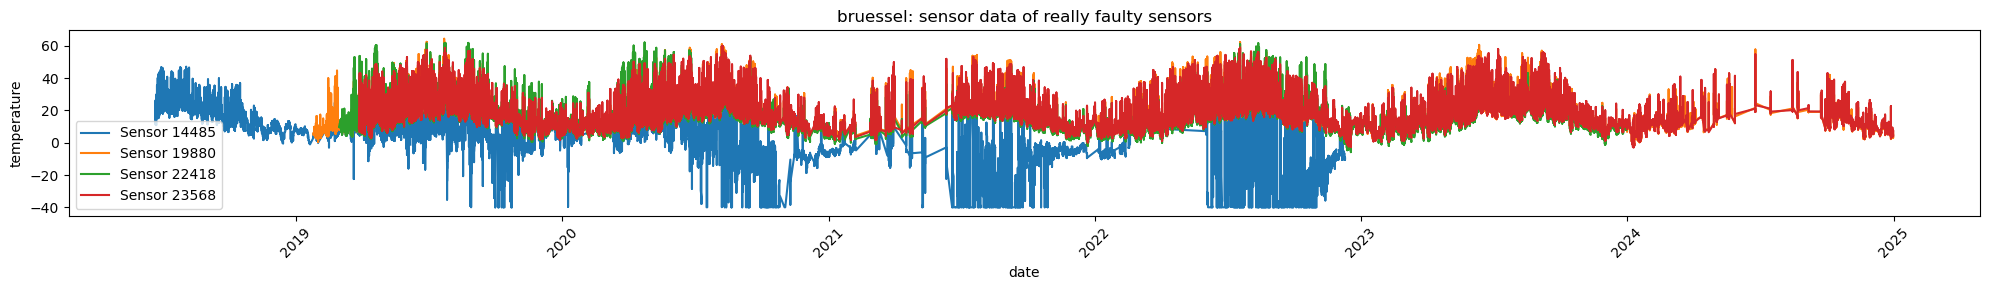

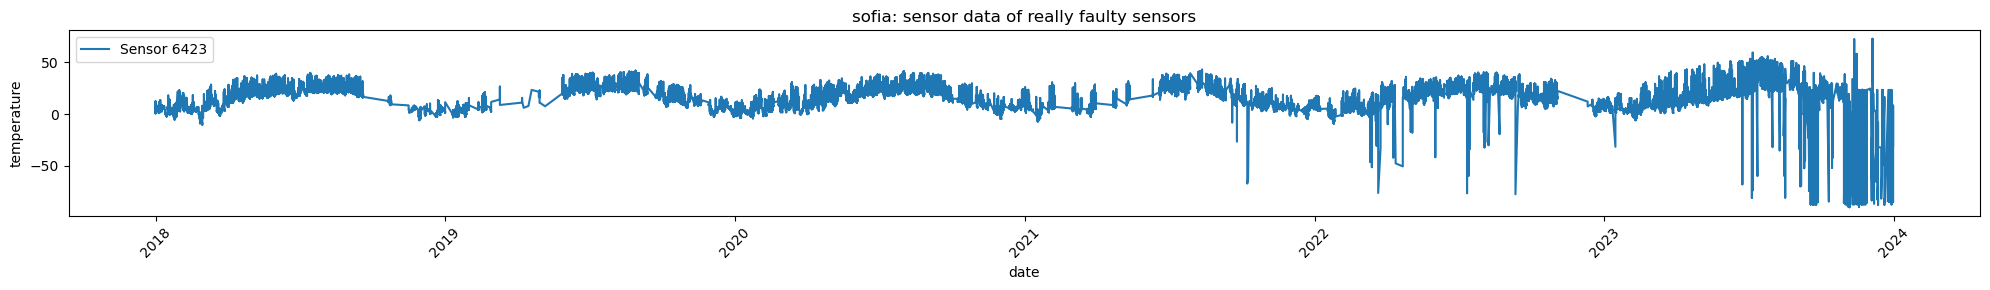

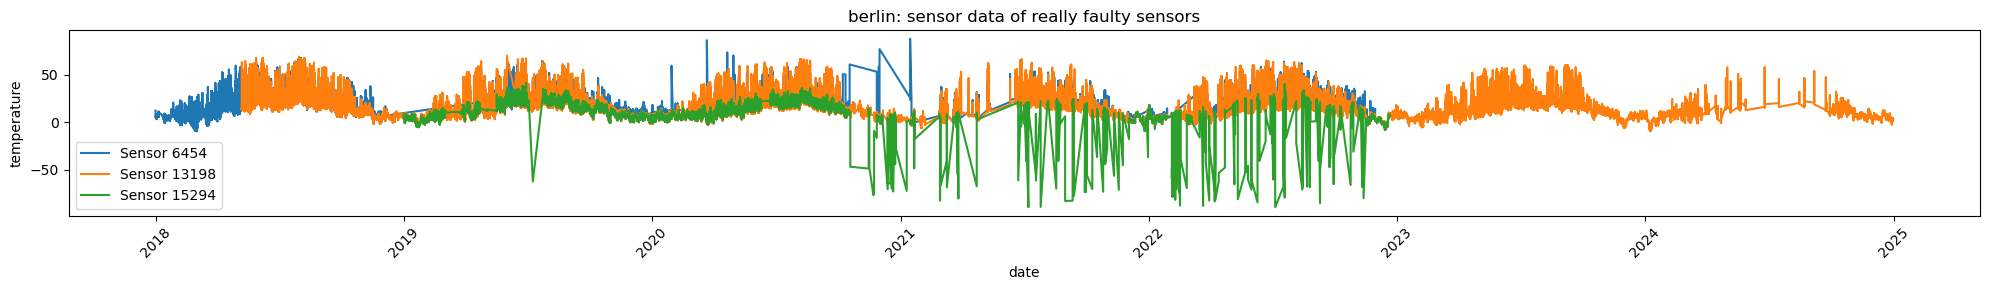

In [13]:
#zeigt die messreihen der betreffenden sensoren
for i in range(3):
    if len(bad_sensors[i]) > 0: 
        bad_data = dfs[i][dfs[i]["sensor_id"].isin(bad_sensors[i])]
        plot_bads(bad_data, places[i])


In [14]:
# erstelle eine gefilterte Liste filtered_dfs
filtered_dfs = []
for i in range(3):
    result = dfs[i][~dfs[i].isin(outliers[i].to_dict(orient='list')).all(axis=1)]
    result = result[~result["sensor_id"].isin(bad_sensors[i])]
    filtered_dfs.append(result)
    

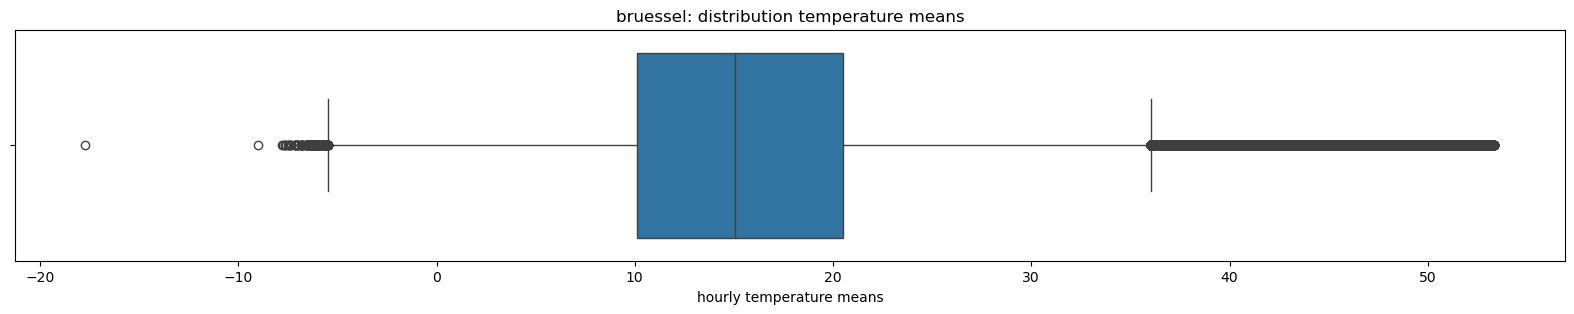

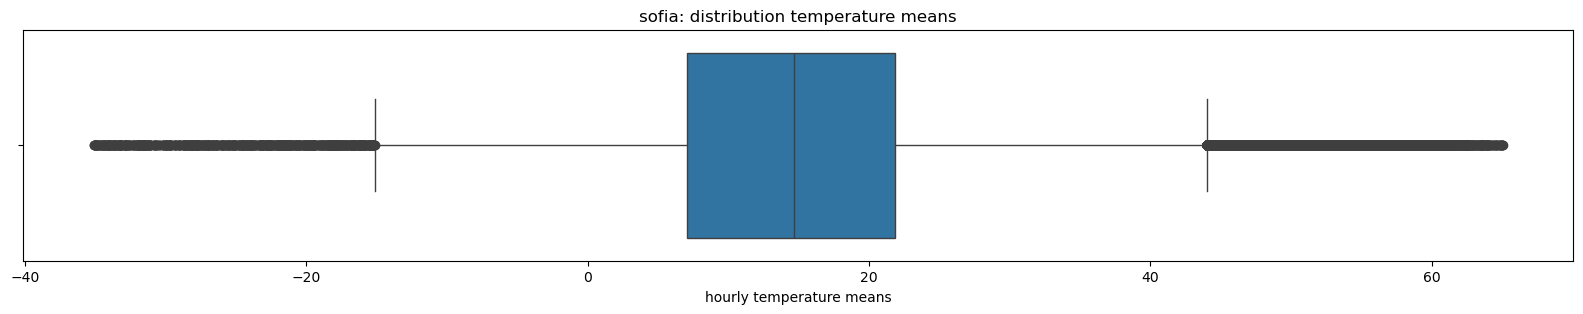

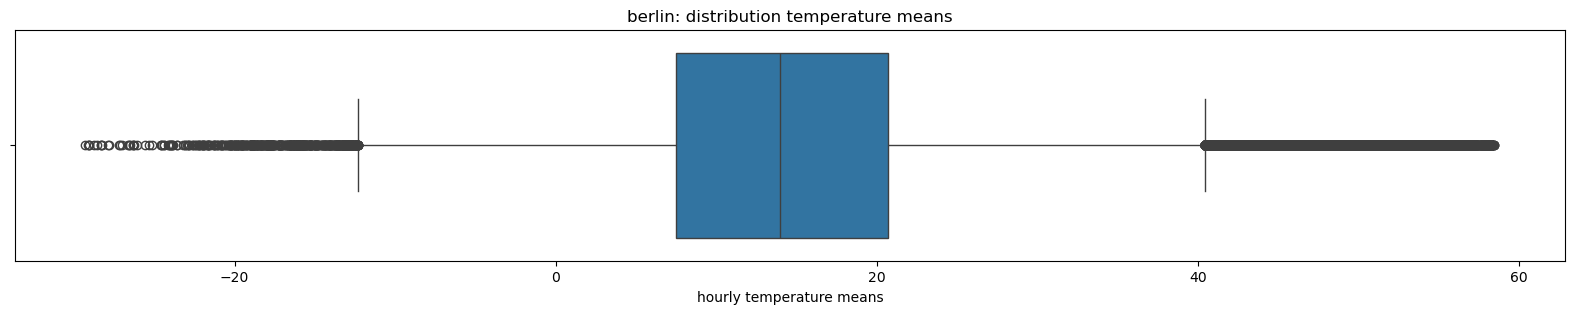

In [15]:
for i in range(3):
    create_boxplot(filtered_dfs[i], places[i])

In [16]:
show_extremes(filtered_dfs)

Messpunkte mit Temperaturwerten > 40° und < -20°
bruessel: 32047, entsprechen 0.41%
sofia: 64835, entsprechen 0.49%
berlin: 20477, entsprechen 0.29%


#### Ideen zur verbesserten Outlieranalyse
- systematisch abweichende Sensoren finden und korrigieren
- Outlierentfernung in beide Extreme getrennt

### 3. Auswertung


Temperaturvarianzen gibt es im Datensatz auf drei Ebenen. 
- täglicher Zyklus
- jährlicher Zyklus
- Varianzen im Temperaturverlauf der Jahre

#### 3.1 Erster Überblick: Tägliche Mittelwerte


In [17]:
def calc_daily_means(df):
    return df.groupby(['year', 'date'])['temperature_mean'].mean().reset_index()

def plot_overview(df, place):
    plt.figure(figsize=(20,3))
    for i, year in enumerate(years):
        year_data = df[df['year'] == year]
        plt.plot(year_data['date'], year_data['temperature_mean'], label=str(year))
    plt.xlabel('daily means')
    plt.ylabel('mean temperature')
    plt.title(place + " sequential")
    plt.legend()
    plt.show()
    plt.figure(figsize=(20,3))
    for year in years:
        year_data = df[df['year'] == year]
        day_of_year = year_data['date'].dt.dayofyear
        plt.plot(day_of_year, year_data['temperature_mean'], label=str(year))
    plt.legend()
    plt.xlabel('days')
    plt.ylabel('mean temperature')
    plt.xlim(1, 366)  # Schaltjahre
    plt.title(place + " year")
    plt.show()

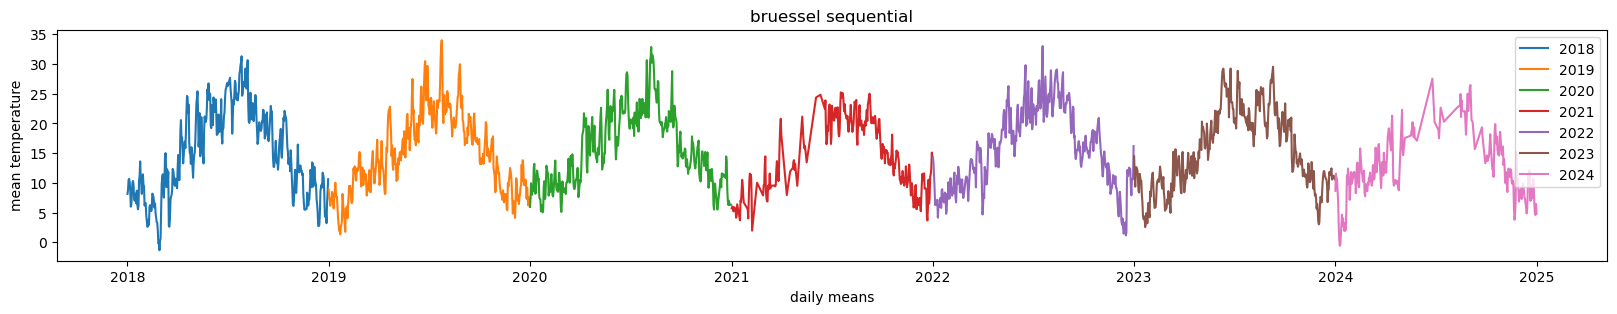

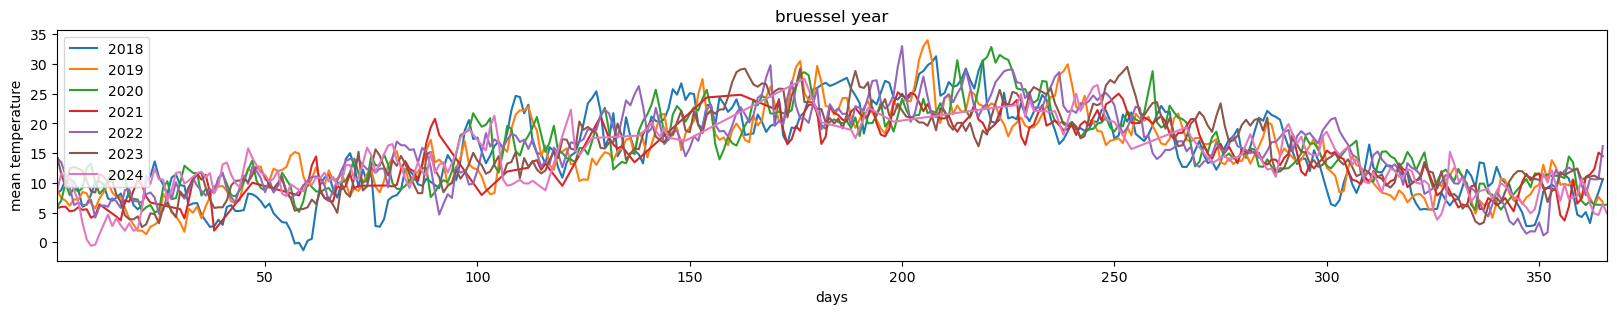

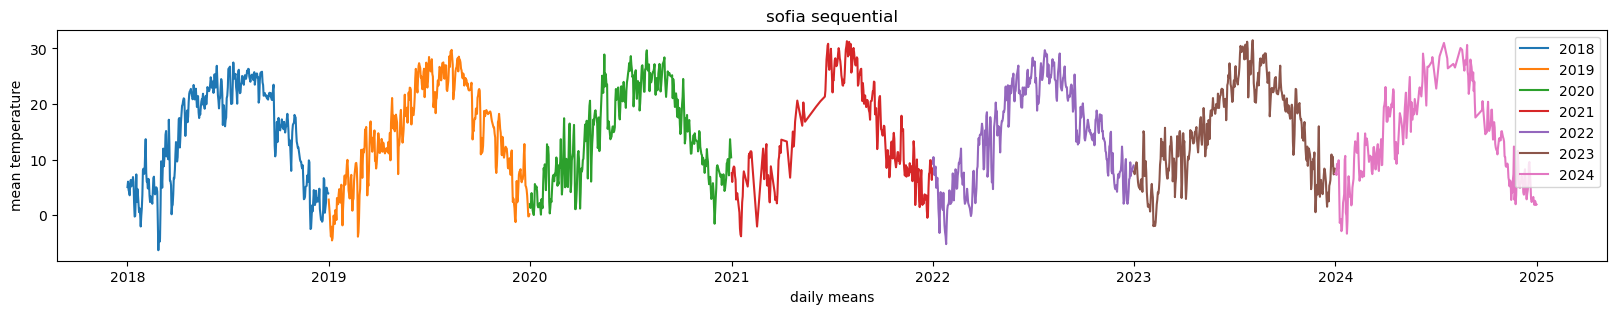

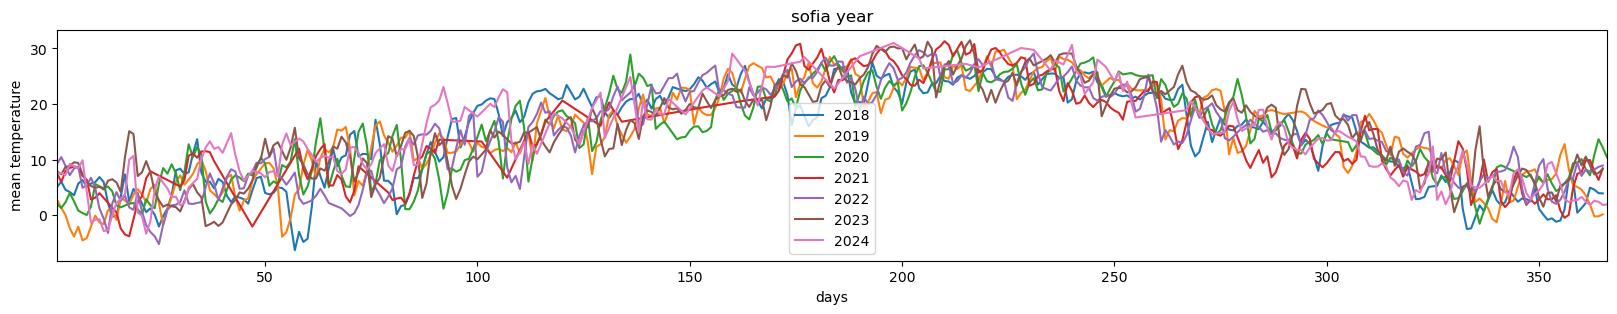

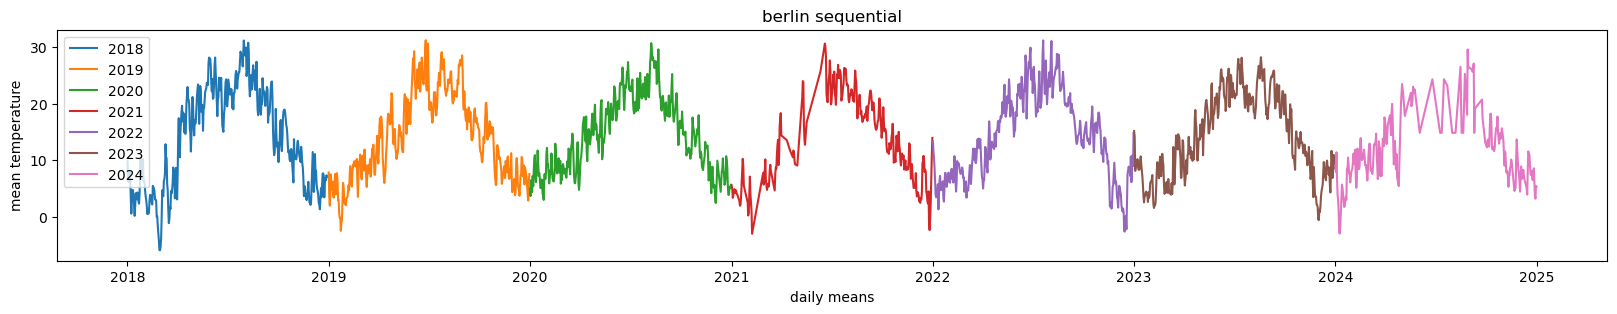

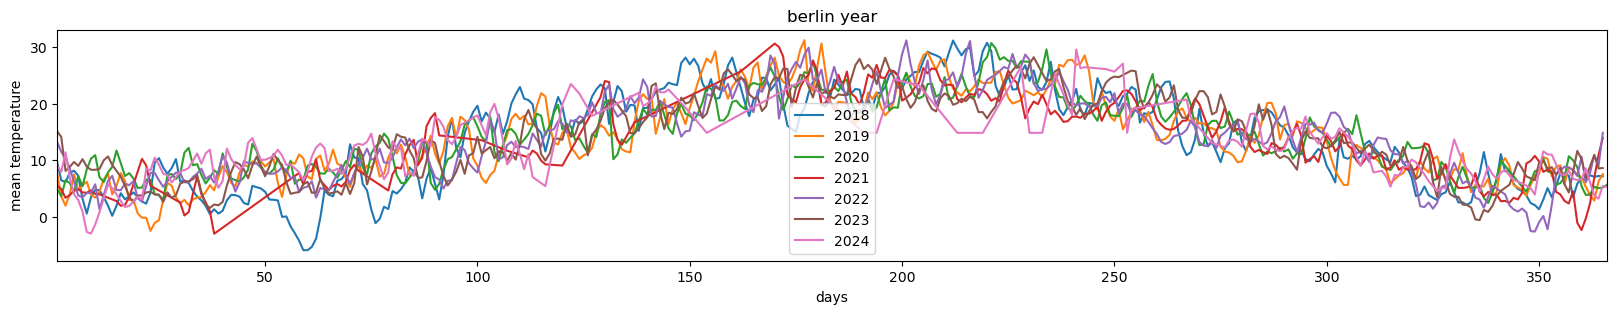

In [18]:
for i in range(3):
    daily_means = calc_daily_means(filtered_dfs[i])
    plot_overview(daily_means, places[i])

#### 3.2 Jährliche Mittelwerte

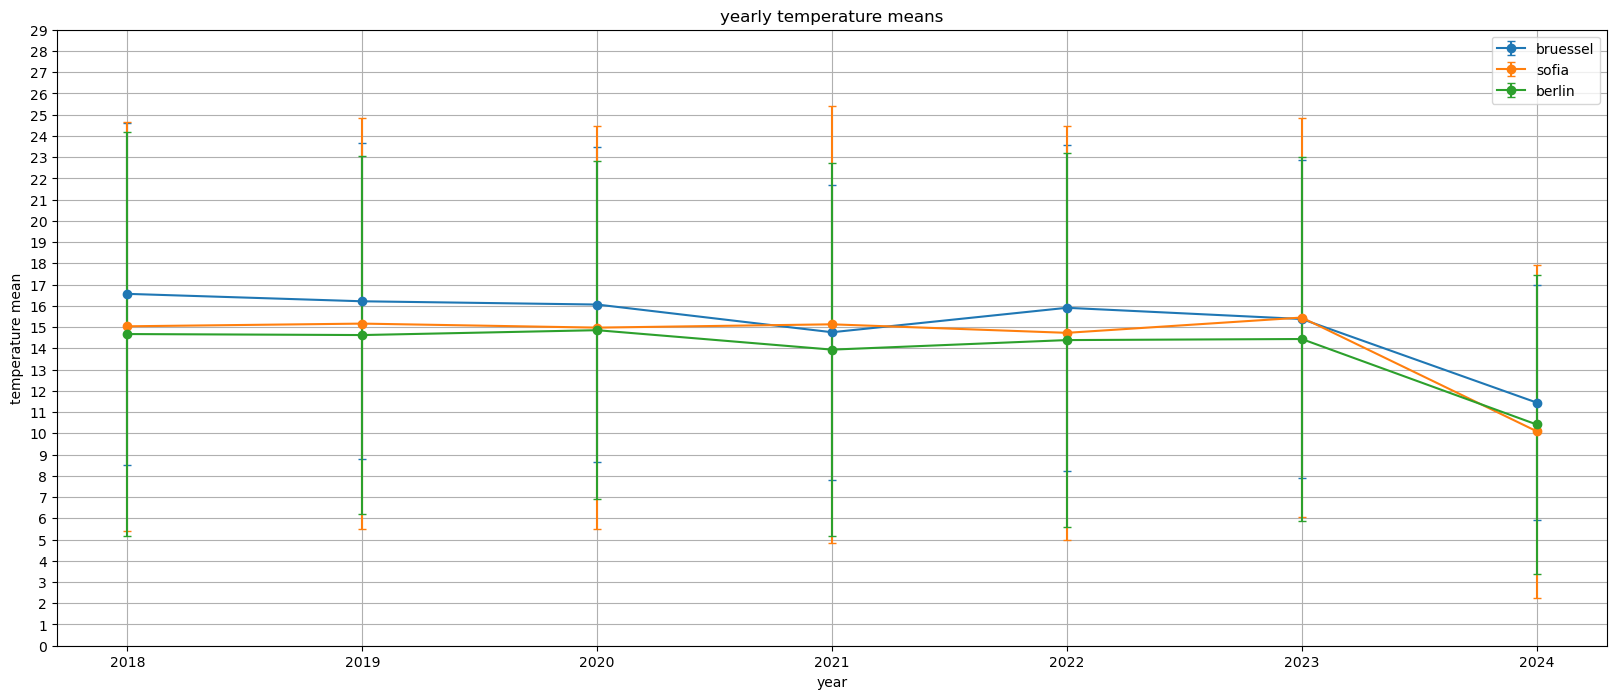

In [19]:
plt.figure(figsize=(20,8))
for i in range(3):
    
    yearly_means = filtered_dfs[i].groupby(['year'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    
    plt.errorbar(
        yearly_means["year"], 
        yearly_means["mean"], 
        yerr=yearly_means["std"], 
        label=places[i], 
        capsize=3,  
        fmt='-o'   
    )
plt.yticks(np.arange(0,30))

plt.grid(visible = True)
plt.legend()
plt.xlabel("year")
plt.ylabel("temperature mean")
plt.title("yearly temperature means")
plt.show()


#### Vgl. für diesen und den folgenden Graph das notebook für die Städte mit weniger Messdaten.

#### 3.3 Monatliche Mittelwerte

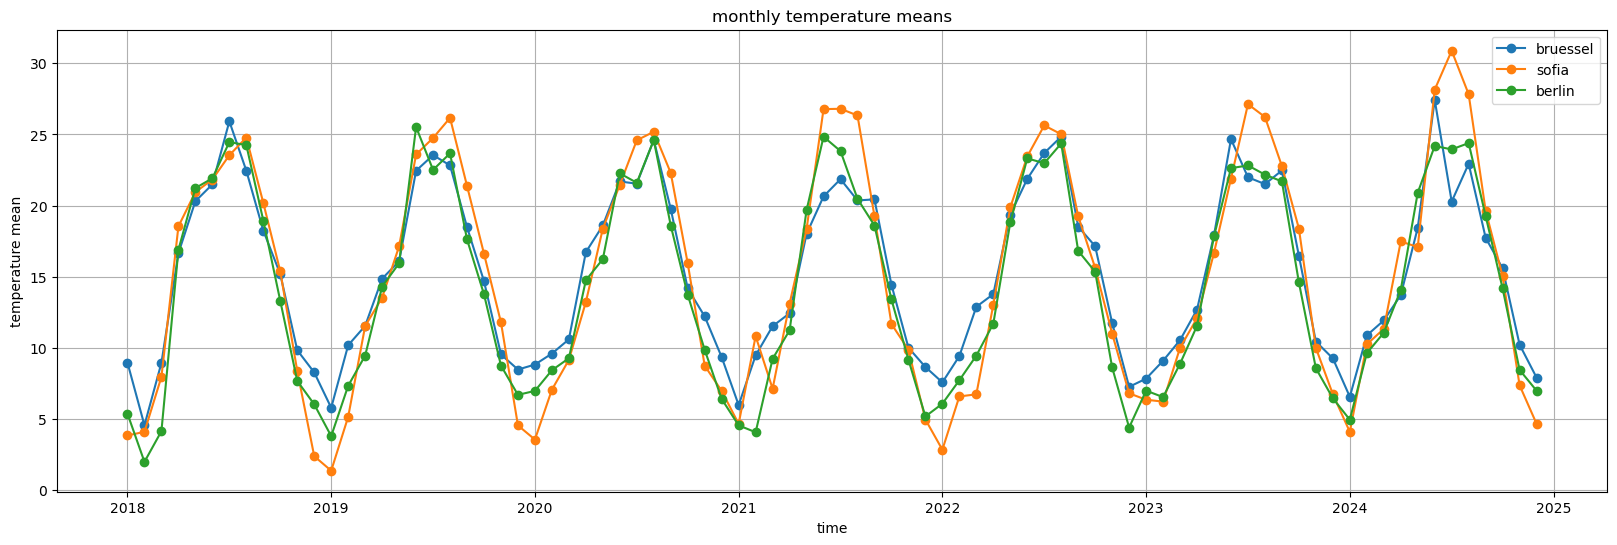

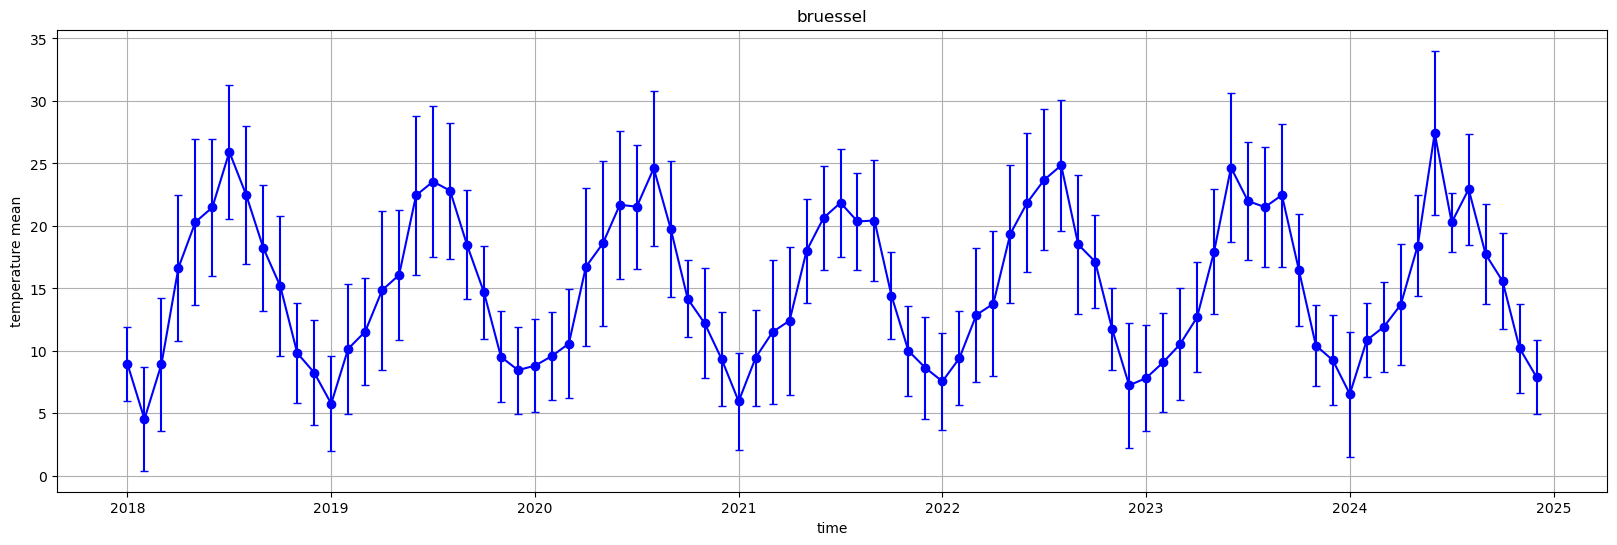

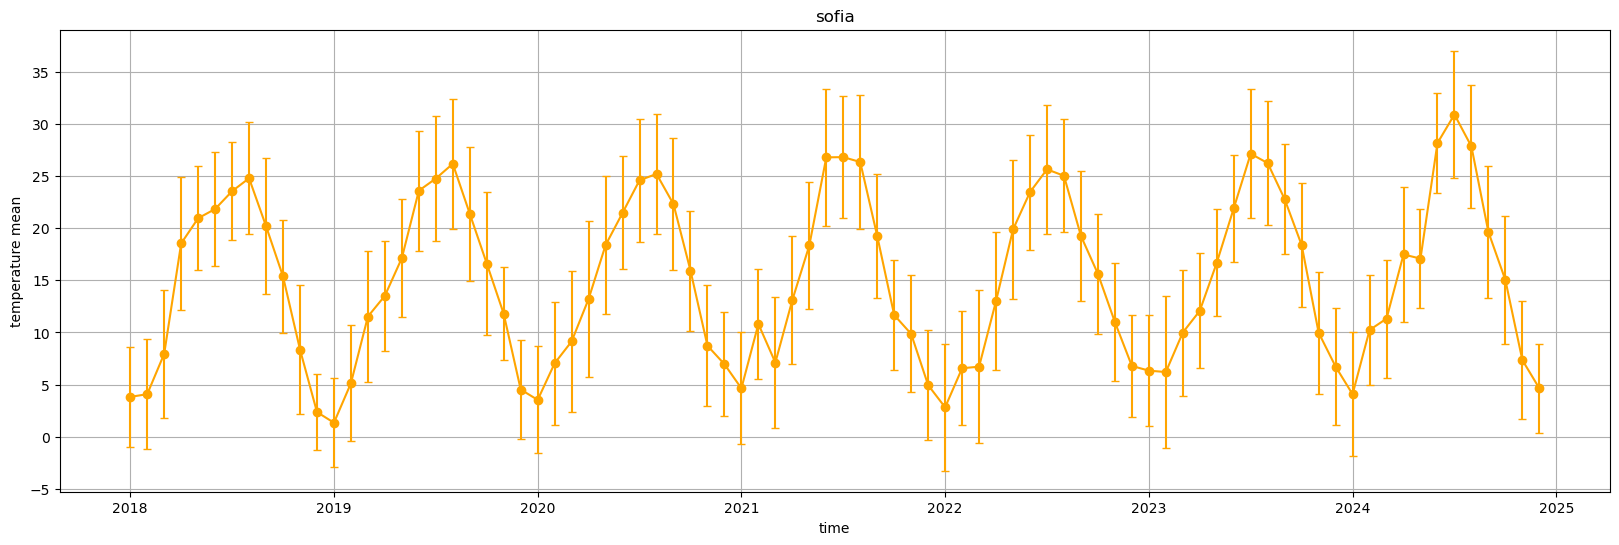

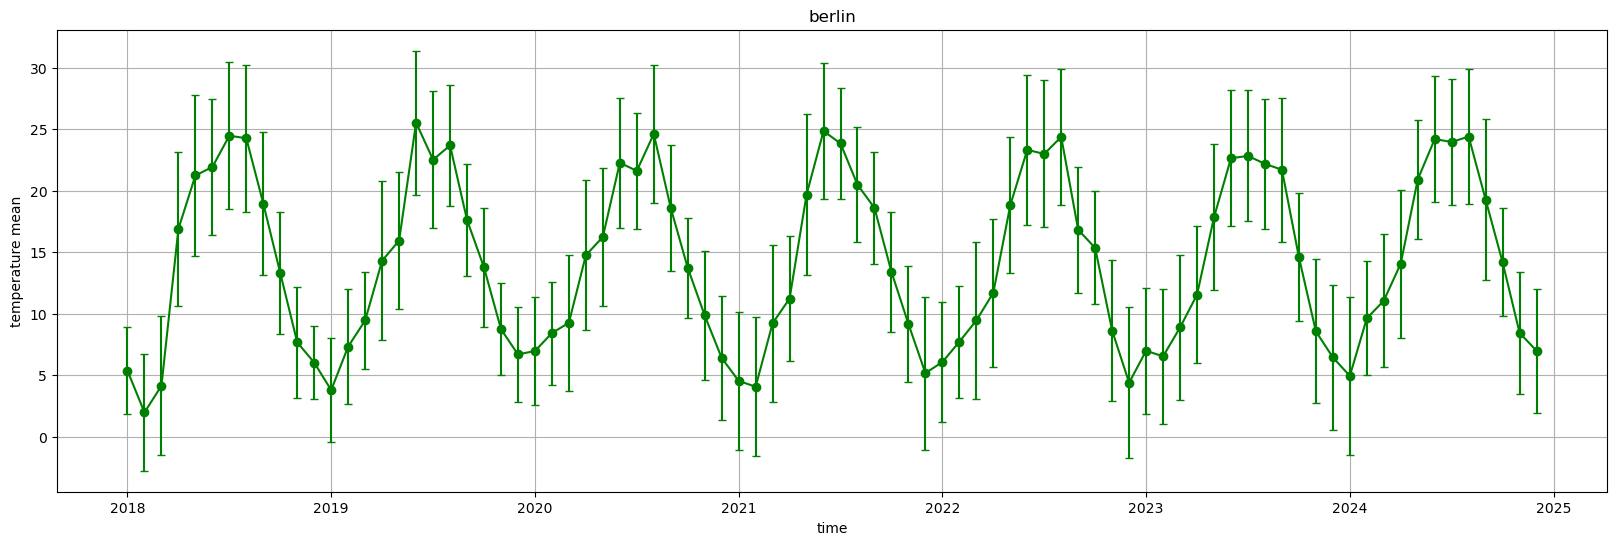

In [20]:
#eine Spalte für die Monate ergänzen
for i in range(3):
    filtered_dfs[i]['date'] = pd.to_datetime(filtered_dfs[i]['date'])  
    filtered_dfs[i]['month'] = filtered_dfs[i]['date'].dt.month       

# monatliche Mittel alle drei Städte
plt.figure(figsize = (20,6))
plt.grid(visible = True)
for i in range(3):

    stats = filtered_dfs[i].groupby(['year', 'month'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    stats['year_month'] = stats['year'] + (stats['month'] - 1) / 12
    plt.plot(
        stats["year_month"], 
        stats["mean"],  
        label=places[i],
        marker = 'o'
    )
plt.legend()
plt.xlabel("time")
plt.ylabel("temperature mean")
plt.title("monthly temperature means")
plt.show()

#Städe einzeln
colors = ["blue", "orange", "green"]
for i in range(3):
    plt.figure(figsize = (20,6))
    plt.grid(visible = True)
    
    stats = filtered_dfs[i].groupby(['year', 'month'])['temperature_mean'].agg(['mean', 'std']).reset_index()
    stats['year_month'] = stats['year'] + (stats['month'] - 1) / 12

    plt.errorbar(
        stats["year_month"], 
        stats["mean"], 
        yerr=stats["std"], 
        label=places[i], 
        capsize=3, 
        fmt='-o',
        c = colors[i]
    )
    plt.xlabel("time")
    plt.ylabel("temperature mean")
    plt.title(places[i])
    plt.show()


#### 3.4 Thermoisoplethendiagramme

In [21]:
#berechnet für jedes Jahr/Tag/Stunde die Mittelwerte
def calc_hourly_means(df):
    return df.groupby(['date', 'year','hour'])['temperature_mean'].mean().reset_index()

#zeigt die Daten als Scatterplot
def plot_temperature_scatter(data, place, year):
    plt.figure(figsize=(18, 4))
    scatter = plt.scatter(data.date, data.hour, c=data.temperature_mean, cmap="gist_rainbow_r")
    plt.colorbar(scatter, label='Temperature (°C)')
    plt.xlabel('date')
    plt.ylabel('hour')
    plt.title(f'{place}, {year}')
    plt.show()

#zeigt die Daten als Contourplot
def plot_temperature_contour(hourly_means_per_year, place, year):
    pivot = hourly_means_per_year.pivot_table(index='hour', columns='date', values='temperature_mean')
    x = np.array(pivot.columns)
    y = np.array(pivot.index)
    z = np.array(pivot)
    z = np.nan_to_num(z, nan=-0.0)
    plt.figure(figsize=(16, 4))
    contour = plt.contourf(x, y, z, levels=np.linspace(z.min(), z.max(), 100), cmap='gist_rainbow_r', vmin=z.min(), vmax=z.max())
    plt.colorbar(contour, label='Temperature (°C)')
    plt.xlabel('Date')
    plt.ylabel('Hour')
    plt.title(f'{place}, {year}')
    plt.show()

In [22]:
#erstellt ein Liste mit Dataframes: für jedes Jahr/Ort alle stündlichen Mittelwerten
hourly_means_per_year = []
for i in range(3):
    hourly_means_place = calc_hourly_means(filtered_dfs[i])
    for year in years:
        data = hourly_means_place[hourly_means_place['year'] == year]
        hourly_means_per_year.append(data)  

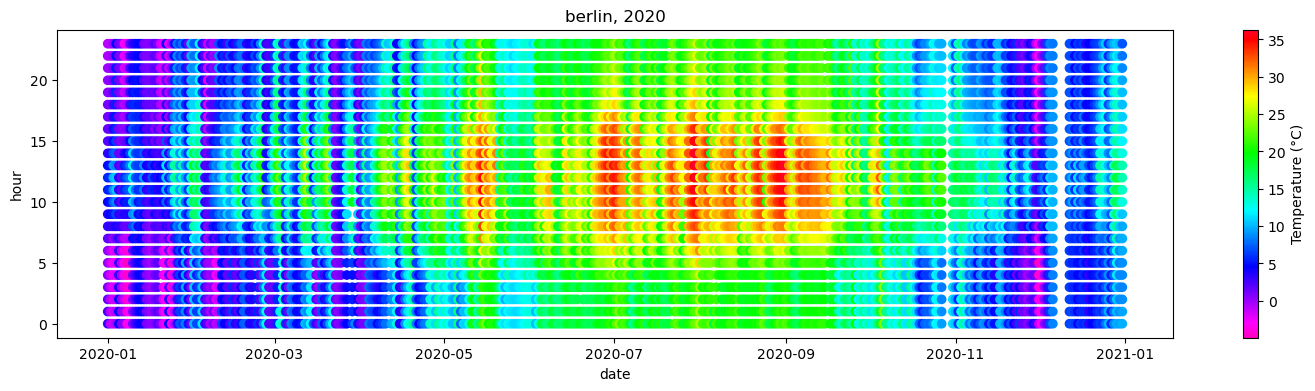

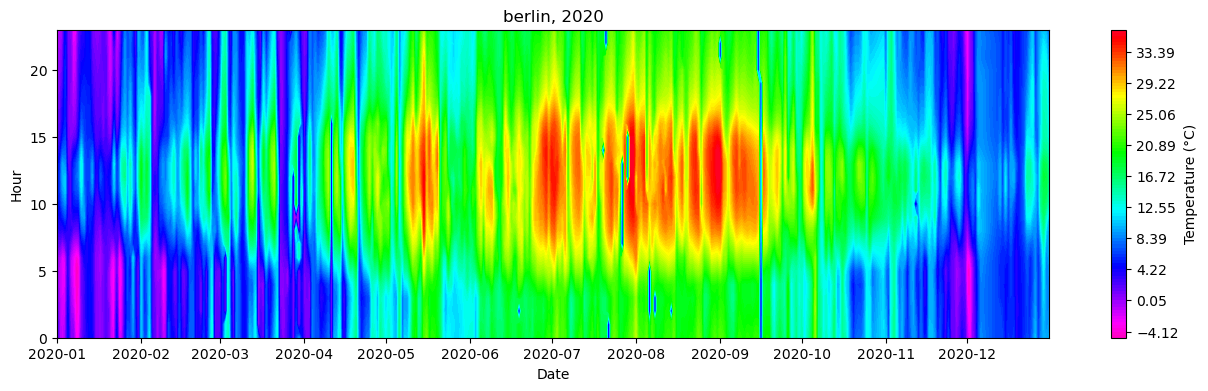

In [23]:
#Beispiel für ein Jahr
plot_temperature_scatter(hourly_means_per_year[9], "berlin", "2020")
plot_temperature_contour(hourly_means_per_year[9], "berlin", "2020")

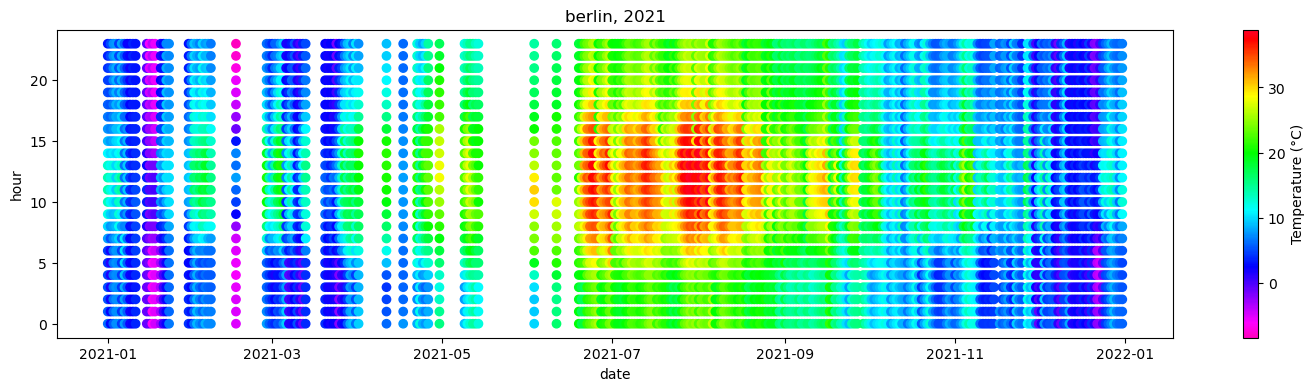

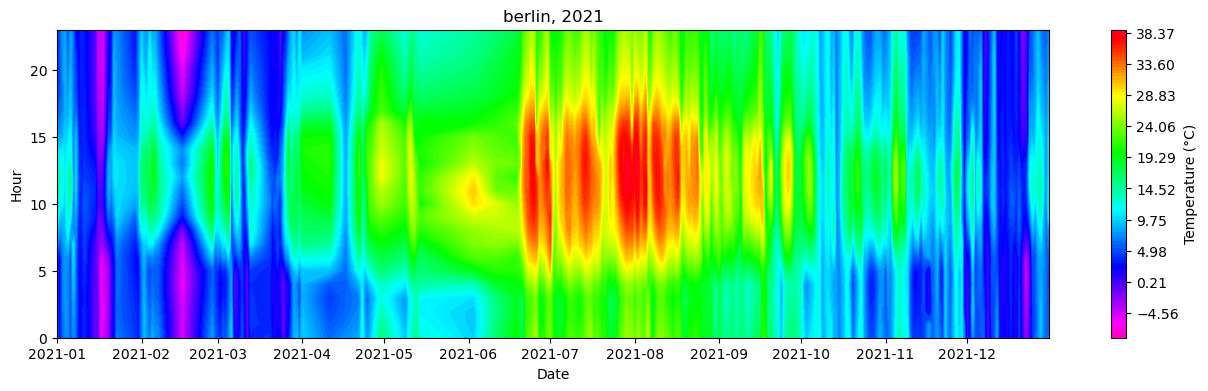

In [24]:
#Beispiel für ein Jahr mit fehlenden Daten
plot_temperature_scatter(hourly_means_per_year[10], "berlin", "2021")
plot_temperature_contour(hourly_means_per_year[10], "berlin", "2021")

In [25]:
#berechnet stündliche Mittelwerte über alle Jahre
def calc_hourly_means_all_years(df):
    df['day_of_year'] = df['date'].dt.dayofyear
    return df.groupby(['day_of_year', 'hour'])['temperature_mean'].mean().reset_index()

In [26]:
#je eine Dataframe pro Ort mit den stündlichen Mittelwerten
hourly_means_all_years = []
for i in range(3):
    hourly_means_all_years.append(calc_hourly_means_all_years(filtered_dfs[i]).copy().rename(columns= {"day_of_year": "date"}))     

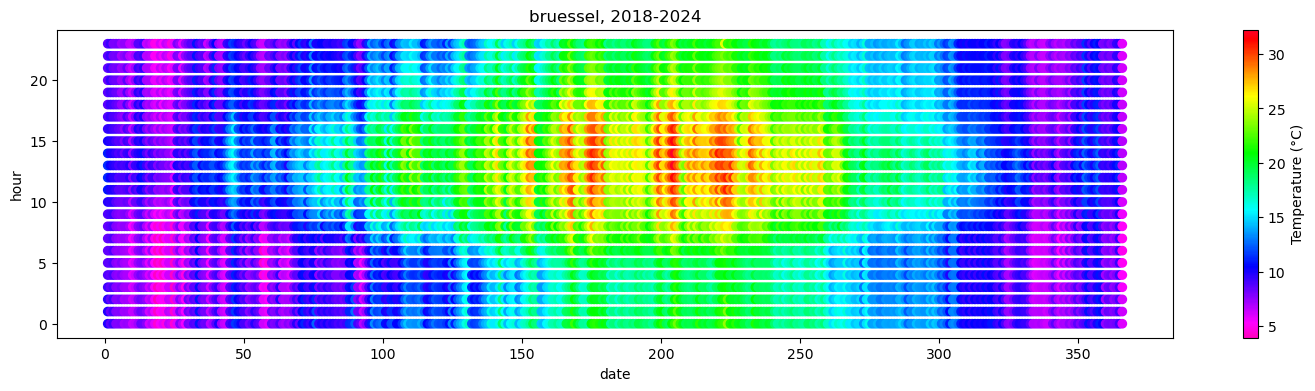

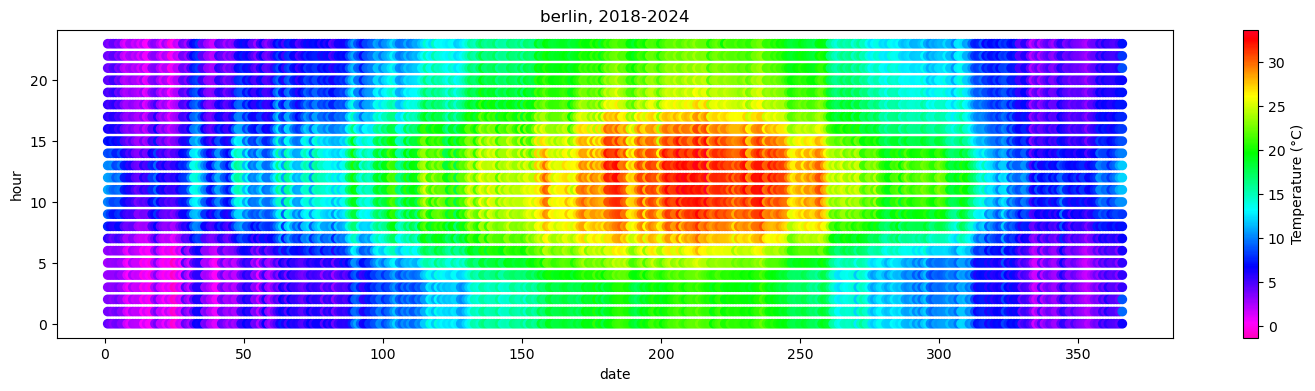

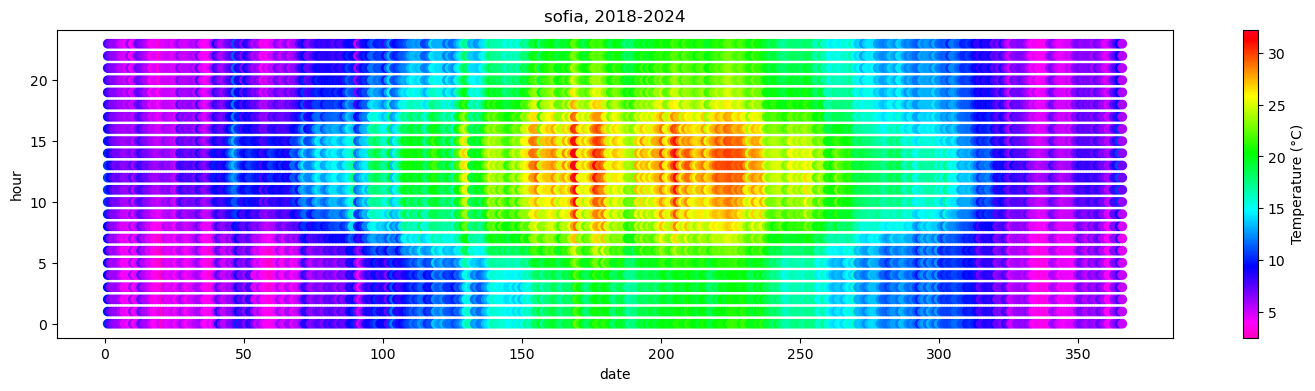

In [27]:
#die Scatterplots
plot_temperature_scatter(hourly_means_all_years[0],"bruessel","2018-2024")
plot_temperature_scatter(hourly_means_all_years[1],"berlin","2018-2024")
plot_temperature_scatter(hourly_means_all_years[2],"sofia","2018-2024")

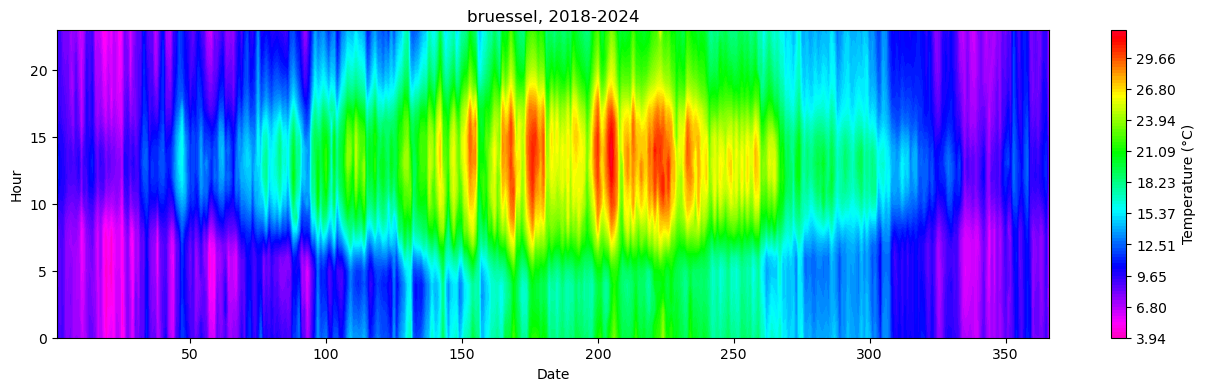

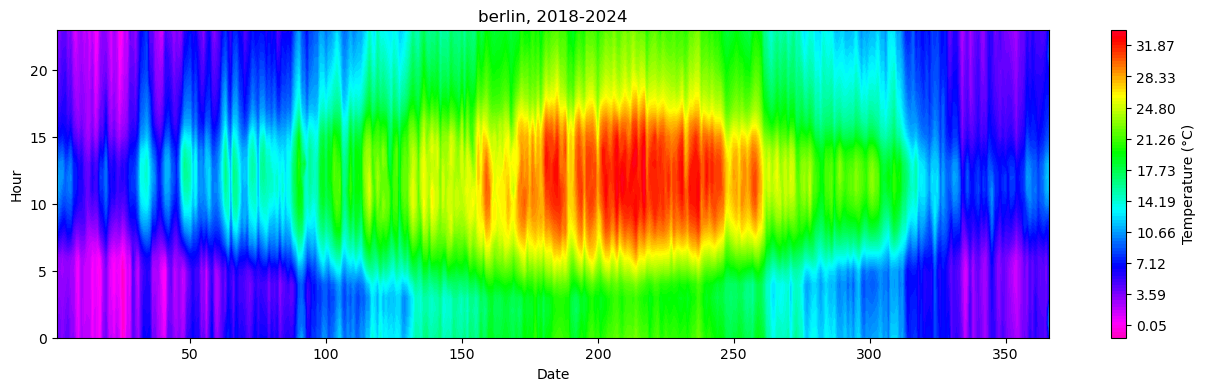

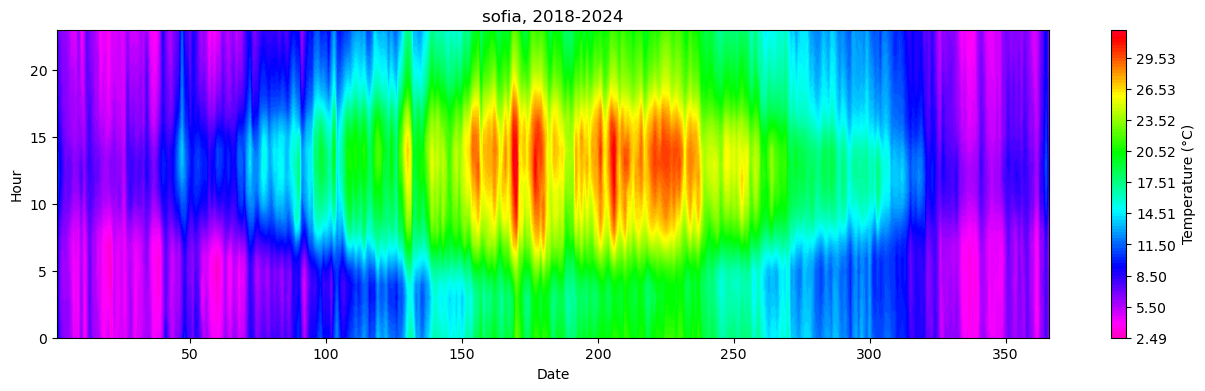

In [28]:
#die Contourplots
plot_temperature_contour(hourly_means_all_years[0],"bruessel","2018-2024")
plot_temperature_contour(hourly_means_all_years[1],"berlin","2018-2024")
plot_temperature_contour(hourly_means_all_years[2],"sofia","2018-2024")

#### 3.5 Differenz-Thermoisoplethendiagramme

In [29]:
bruessel = hourly_means_per_year[0:7]
sofia = hourly_means_per_year[7:14]
berlin = hourly_means_per_year[14:21]

In [30]:
#gibt einen dataframe mit den Temperaturdifferenzen jeder Stunde für ein Jahr
def calc_diffs(data, data2):
    df1 = data.copy()
    df1["day_of_year"] = pd.to_datetime(df1["date"]).dt.dayofyear
    df1.drop(columns=["date", "year"], inplace=True)
    df2 = data2.copy()
    df2["day_of_year"] = pd.to_datetime(df2["date"]).dt.dayofyear
    df2.drop(columns=["date", "year"], inplace=True)
    merged_df = pd.merge(df1, df2, on=['day_of_year', 'hour'], suffixes=('_df1', '_df2'), how='outer')
    merged_df['temperature_diff'] = merged_df['temperature_mean_df1'] - merged_df['temperature_mean_df2']
    merged_df = merged_df.rename(columns= {"day_of_year": "date", "temperature_diff": "temperature_mean"})
    return merged_df

#gibt eine Liste mit Dataframes für jedes Paar aufeinanderfolgender Jahre (und macht ggf. einen Plot)
def calc_and_show_all_diffs(data, place):
    all_diffs = []
    for i in [0,1,2,3,4,5]:
        merged_df = calc_diffs(data[i], data[i+1])
        year = str(years[i]) + "/" + str(years[i+1])
        #plot_temperature_scatter(merged_df, place, year)
        all_diffs.append(merged_df)
    return all_diffs
    

In [31]:
#Differenzen für Paare von Jahren
bruessel_diffs = calc_and_show_all_diffs(bruessel, "hourly differences bruessel")
sofia_diffs = calc_and_show_all_diffs(sofia, "hourly differences sofia")
berlin_diffs = calc_and_show_all_diffs(berlin, "hourly differences berlin")

In [32]:
#gibt einen Dataframe mit den gemittelten Temperaturdifferenzen für jede Stunde eines Jahres
def calc_mean_diffs(dataframes):
    combined_df = pd.concat(dataframes, ignore_index=True)
    grouped_mean_df = combined_df.groupby(['hour', 'date']).mean().reset_index()
    return grouped_mean_df

In [33]:
#berechnet mittlere Differenzen für alle Städte
bruessel_diff_means = calc_mean_diffs(bruessel_diffs)
sofia_diff_means = calc_mean_diffs(sofia_diffs)
berlin_diff_means = calc_mean_diffs(berlin_diffs)


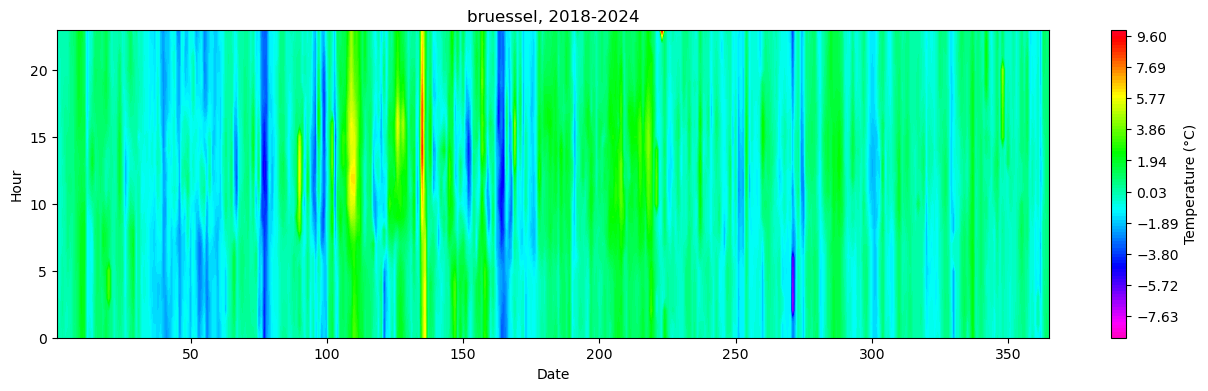

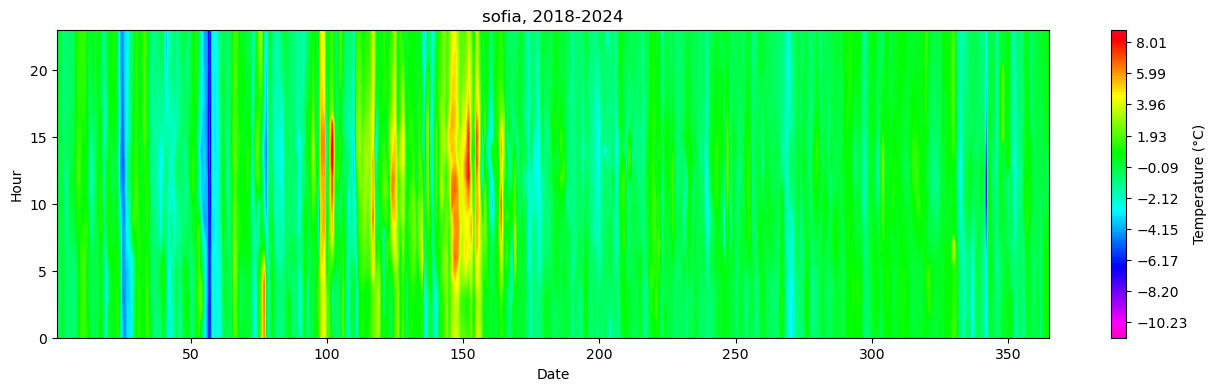

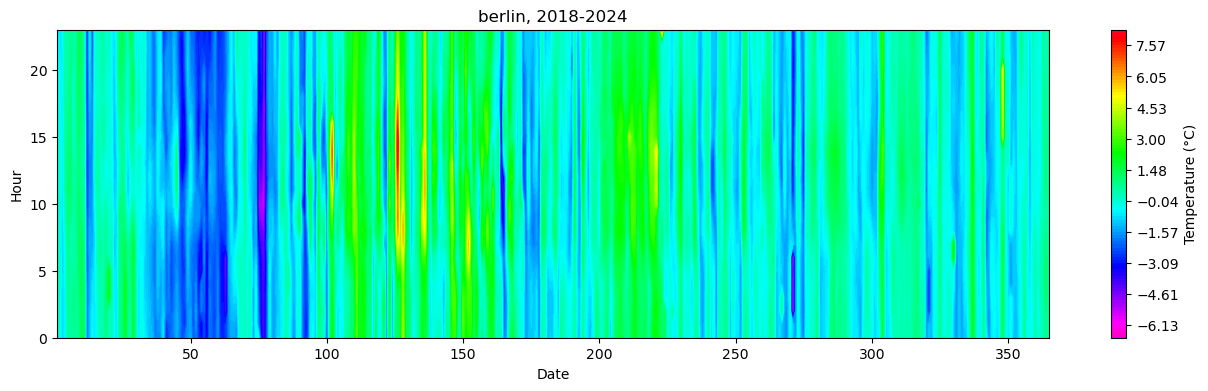

In [34]:
#zeige die mittleren Differenzen als Contour Plot
plot_temperature_contour(bruessel_diff_means, "bruessel", "2018-2024")
plot_temperature_contour(sofia_diff_means, "sofia", "2018-2024")
plot_temperature_contour(berlin_diff_means, "berlin", "2018-2024")


In [35]:
def calc_daily_diff_means(df):
    return df.groupby(['date'])['temperature_mean'].mean().reset_index()

def plot_differences(data, place, year):
    plt.figure (figsize=(20,3))
    plt.grid(visible = True)
    mean = data["temperature_mean"].mean()
    plt.hlines(mean,-2,367, colors = "red", linestyle = "--", label = "mean: " + str(round(mean,2)))
    plt.plot(data["date"], data["temperature_mean"], marker = 'o')
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("temperature mean difference")
    plt.title(place + ": temperature mean differences " + year)
    plt.show()


In [67]:
bruessel_daily_diff_means = calc_daily_diff_means(bruessel_diff_means)
sofia_daily_diff_means = calc_daily_diff_means(sofia_diff_means)
berlin_daily_diff_means = calc_daily_diff_means(berlin_diff_means)

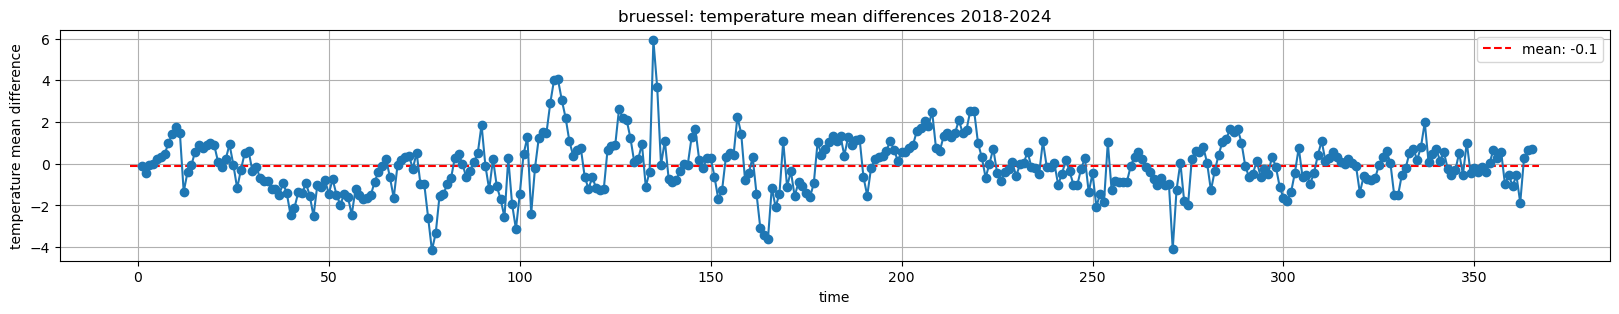

In [68]:
plot_differences( bruessel_daily_diff_means, "bruessel", "2018-2024")

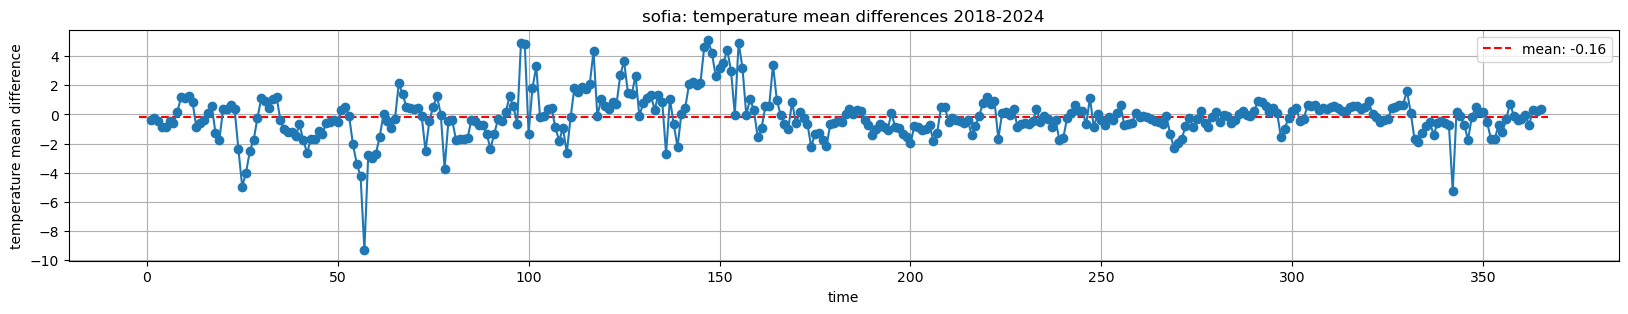

In [69]:
plot_differences( sofia_daily_diff_means, "sofia", "2018-2024")

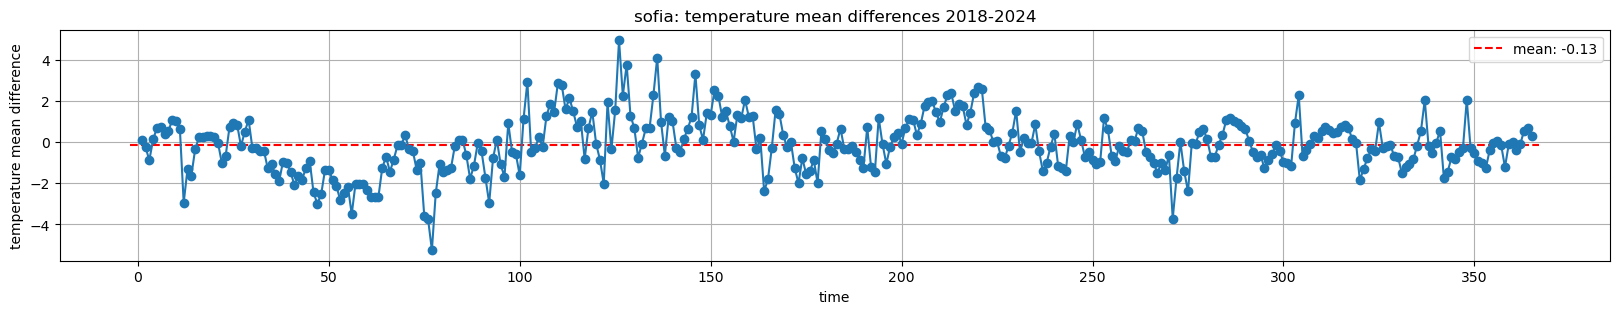

In [70]:
plot_differences( berlin_daily_diff_means, "sofia", "2018-2024")

In [71]:
def plot_seasonal_differences(data, place, year):
    plt.figure (figsize=(20,6))
    plt.grid(visible=True)
    
    
    # Define seasons based on day of year
    seasons = {
        'Winter': (list(range(1, 79)) + list(range(355, 366))),
        'Spring': range(79, 172),
        'Summer': range(172, 265),
        'Autumn': range(265, 355)
    }
    
    # Compute seasonal means and plot horizontal lines
    for season, days in seasons.items():
        seasonal_data = data[data['date'].isin(days)]
        if not seasonal_data.empty:
            season_mean = seasonal_data['temperature_mean'].mean()
            if season == "Winter":
                plt.hlines(season_mean, -2,79, colors='red', linestyle='--')
                plt.hlines(season_mean, 355,366, colors='red', linestyle='--', label=f'{season} mean: {round(season_mean, 2)}')
            else: 
                plt.hlines(season_mean, min(days), max(days), 
                       colors='red', linestyle='--', label=f'{season} mean: {round(season_mean, 2)}')
    
    # Plot daily temperature mean
    plt.plot(data['date'], data['temperature_mean'], marker='o', linestyle='-', label='Daily Mean')
    
    plt.legend()
    plt.xlabel("Day of Year")
    plt.ylabel("Temperature Mean Difference")
    plt.title(f"{place}: Temperature Mean Differences {year}")
    plt.show()


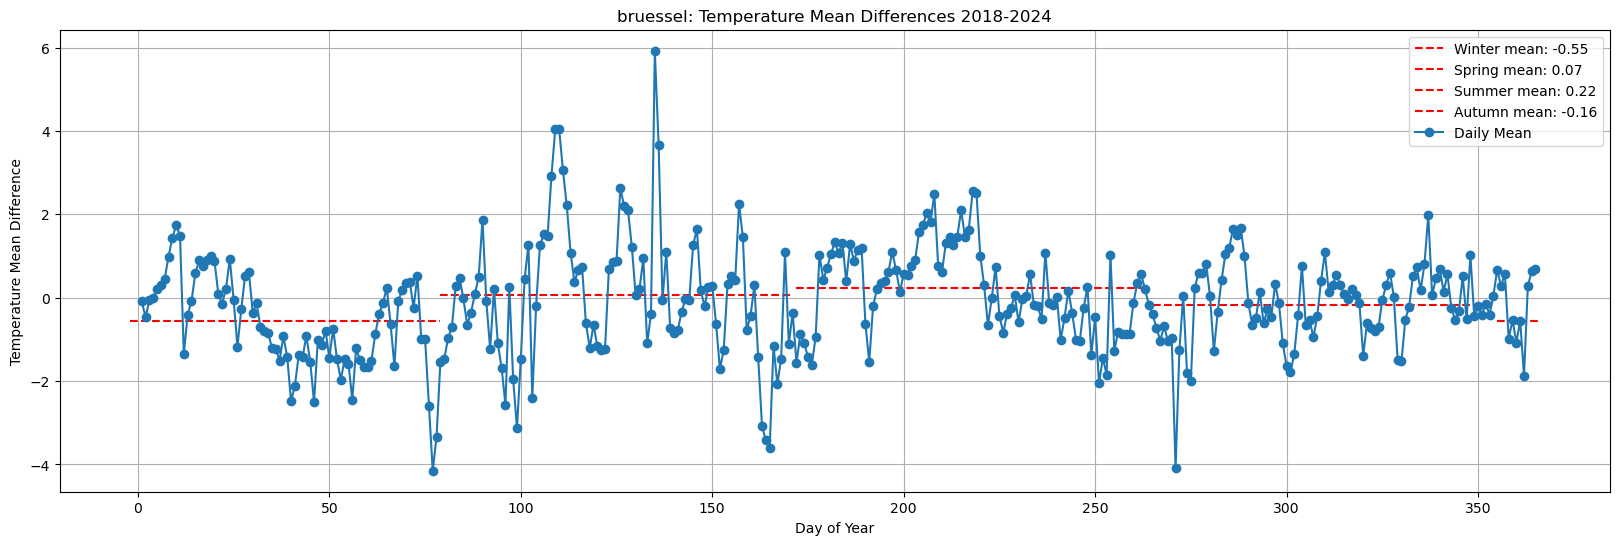

In [73]:
plot_seasonal_differences( bruessel_daily_diff_means, "bruessel", "2018-2024")

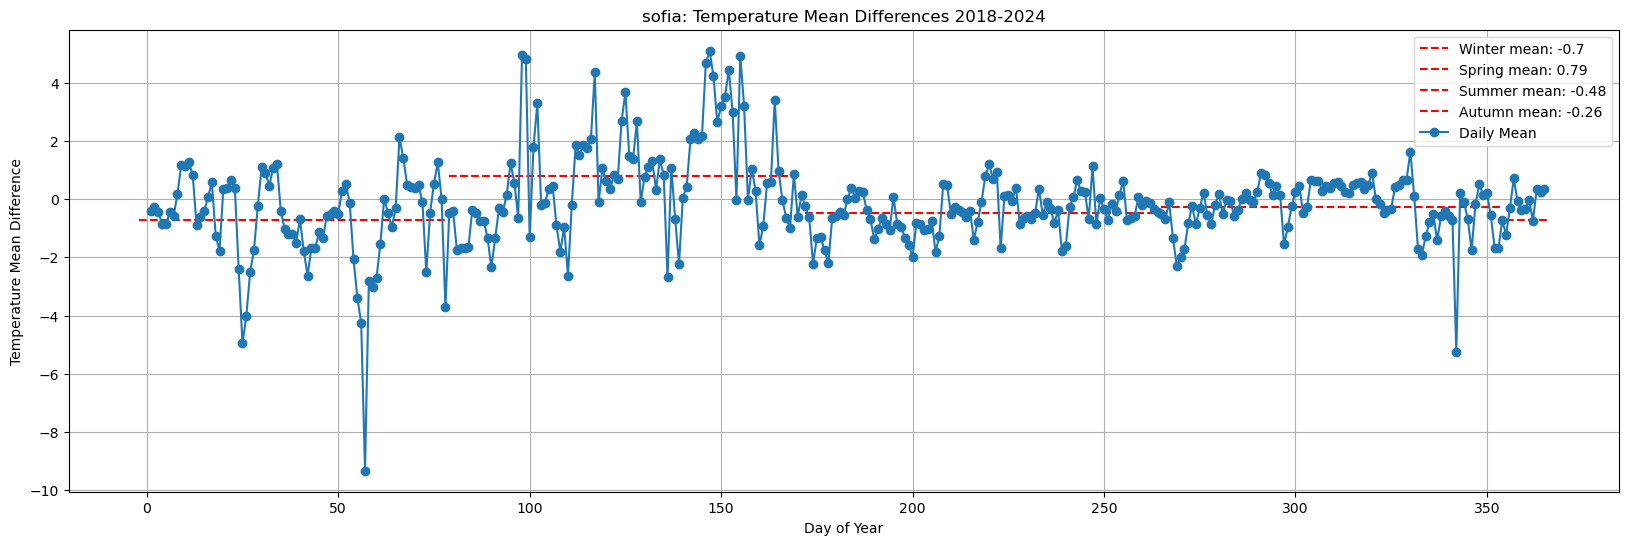

In [74]:
plot_seasonal_differences(sofia_daily_diff_means, "sofia", "2018-2024")

In [ ]:
plot_seasonal_differences( berlin_daily_diff_means, "berlin", "2018-2024")